# Capstone - Stock prediction

In [290]:
#Importing required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
import glob

# Loading all Data

In [292]:
#The different data sets used are 
# Stock daily movement dataset
# NSE, BSE, Crude, Gold, Silver, NSE secoral indices (corresponding to selected stock)
# Inflation rate
# Nasdaq composite, Nasdaq 100, Nikkei

In [9]:
input_files = glob.glob('*.csv')
all_inputs_list = []
for filename in input_files:
    start = filename.find('Input') + 21
    end = filename.find('.csv', start)
    temp_df = pd.read_csv(filename)
    print(filename[start:end], 'shape is', temp_df.shape)
    all_inputs_list.append({filename[start:end]:temp_df})

 shape is (1320, 7)
s shape is (6, 2)
s shape is (1314, 7)
d) shape is (1373, 7)
s shape is (1375, 7)
d) shape is (6, 2)
) shape is (1320, 7)
y(Jan-2015 to may-2020) shape is (1321, 2)
 shape is (1387, 7)
 shape is (1320, 7)
 shape is (1320, 7)
 shape is (1320, 7)
 shape is (1320, 7)
 shape is (1320, 7)
 shape is (1381, 7)
 shape is (1321, 7)
 shape is (1321, 7)
) shape is (5, 2)
) shape is (1320, 7)
lit) shape is (1, 2)
 shape is (1320, 7)
nd) shape is (1, 2)
ed) shape is (1320, 7)
 shape is (1, 2)
 shape is (23, 2)
 shape is (1320, 7)
 shape is (1400, 7)


In [10]:
input_files

['BSE_SENSEX.csv',
 'CIPLA.NS(Dividend).csv',
 'CIPLA.NS(Modified).csv',
 'Crudeoil_MCX(Modified).csv',
 'Gold_MCX(Modified).csv',
 'HDFCBANK.NS (dividend).csv',
 'HDFCBANK.NS(modified).csv',
 'Inflationrate_monthly(Jan-2015 to may-2020).csv',
 'Nasdaqcomposite.csv',
 'Nifty_Auto.csv',
 'Nifty_Bank.csv',
 'Nifty_Energy.csv',
 'Nifty_IT.csv',
 'Nifty_Pharma.csv',
 'Nikki.csv',
 'NSE_Nifty50.csv',
 'NYSE_top100.csv',
 'RELIANCE.NS(Dividend).csv',
 'RELIANCE.NS(Modified).csv',
 'RELIANCE.NS(Stock split).csv',
 'Silver_MCX(Modified).csv',
 'TATAMOTORS.NS(Dividend).csv',
 'TATAMOTORS.NS(Modified).csv',
 'TCS.NS (Stock split).csv',
 'TCS.NS(Dividend).csv',
 'TCS.NS(Modified).csv',
 'USDINR_FOREX.csv']

In [17]:
#all_inputs_list
#All input dataets are loaded into different dataframes in memory

stock_df = all_inputs_list[0]['RELIANCE.NS(Modified).csv']

nse_df = all_inputs_list[1]['NSE_Nifty50']

bse_df = all_inputs_list[2]['BSE_SENSEX']

crude_df = all_inputs_list[3]['Crudeoil_MCX(Modified)']

gold_df = all_inputs_list[4]['Gold_MCX(Modified)']

silver_df = all_inputs_list[5]['Silver_MCX(Modified)']

inflation_df = all_inputs_list[6]['Inflationrate_monthly']

nse_sectoral_energy_df = all_inputs_list[7]['Nifty_Energy']

nasdaq_composite_df = all_inputs_list[8]['Nasdaqcomposite']

nasdaq_100_df = all_inputs_list[9]['Nasdaqtop100']

nikkei_225_df = all_inputs_list[10]['Nikkei225']

KeyError: 'RELIANCE.NS(Modified).csv'

In [8]:
stock_df

NameError: name 'stock_df' is not defined

# Pre-processing and EDA

In [12]:
#preprocess_one method converts Date field to date datatype
#and plots the time series for the provided column (close price value)

def preprocess_one(df1, plot_by):
    print(df1.info())
    print(df1.describe(include='all').transpose())
    df1['Date'] = pd.to_datetime(df1.Date)
    df1.sort_values(by='Date', inplace=True)
    df1.index = df1['Date']
    plt.figure(figsize=(16,8))
    plt.plot(df1[plot_by], label='Close Price history')
    df1.reset_index(drop=True, inplace=True)
    return df1

In [5]:
print(stock_df.shape)
stock_df = preprocess_one(stock_df, 'Close')

NameError: name 'stock_df' is not defined

In [6]:
#preprocess_two removes the specified special char from field value
#and converts the string type column to specified column type

def preprocess_two(tmp_df, column, to_replace, to_col_fmt):
    tmp_df[column] = tmp_df[column].astype(str).str.replace(to_replace,"")
    #print('dtype of',column,' is ',tmp_df[column].dtype)
    tmp_df[[column]] = tmp_df[[column]].astype(to_col_fmt)
    #print('dtype of',column,' after is ',tmp_df[column].dtype)

In [7]:
#preprocess_three iterates over list of specified columns
#then calls preprocess_two inside for each column to handle special char removal and type conversion

def preprocess_three(df2):
    comma_removal_list = ['Price', 'Open', 'High', 'Low', 'Volume']
    for col in comma_removal_list:
        preprocess_two(df2, col, ",", 'float64')
    other_removal_list = ['Chg%']
    for col in other_removal_list:
        preprocess_two(df2, col, '%', 'float32')
    return df2

In [8]:
#preprocess_four does preprocessing for Volume column, replaces strings to numeric represenation
#all Volumes are converted to millions

def preprocess_four(df4):
    df4['Volume_num'], df4['Volume_unit'] = df4['Volume'].str[:-1], df4['Volume'].str[-1:]
    df4[['Volume_num']] = df4[['Volume_num']].astype('float64')
    print(df4['Volume_unit'].value_counts())
    df4.loc[df4['Volume_unit'] == 'K', 'Volume'] = df4['Volume_num'] * 0.001
    df4.loc[df4['Volume_unit'] == 'M', 'Volume'] = df4['Volume_num'] * 1.0
    df4.loc[df4['Volume_unit'] == 'B', 'Volume'] = df4['Volume_num'] * 1000.0
    df4.drop(['Volume_num', 'Volume_unit'], axis=1, inplace=True)
    #print((df4.loc[df4['Volume'] < 1]).shape[0], (df4.loc[(df4['Volume'] >= 1) & (df4['Volume'] <= 1000)]).shape[0], (df4.loc[df4['Volume'] > 1000]).shape[0])
    return df4

In [300]:
#apply all data preprocessing for all datasets

In [9]:
nse_df = preprocess_four(nse_df)
nse_df = preprocess_three(nse_df)
nse_df = preprocess_one(nse_df, 'Price')

NameError: name 'nse_df' is not defined

K    1009
M     311
Name: Volume_unit, dtype: int64


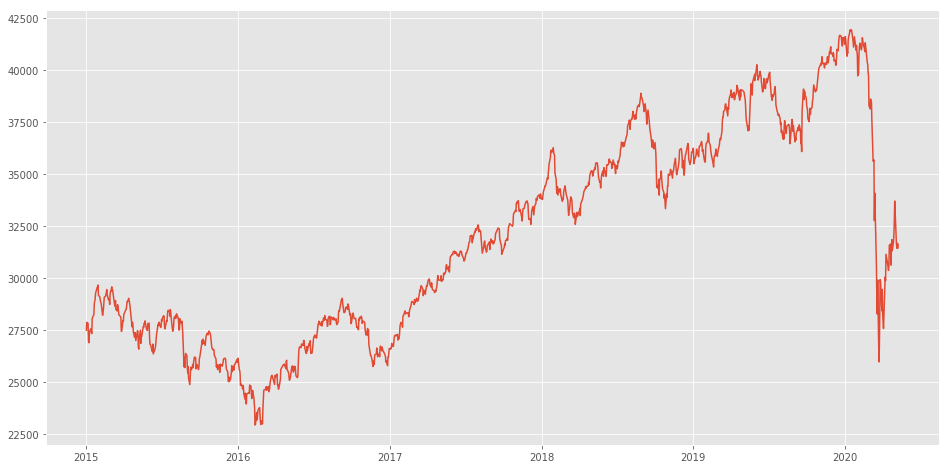

In [302]:
bse_df = preprocess_four(bse_df)
bse_df = preprocess_three(bse_df)
bse_df = preprocess_one(bse_df, 'Price')


K    1375
Name: Volume_unit, dtype: int64


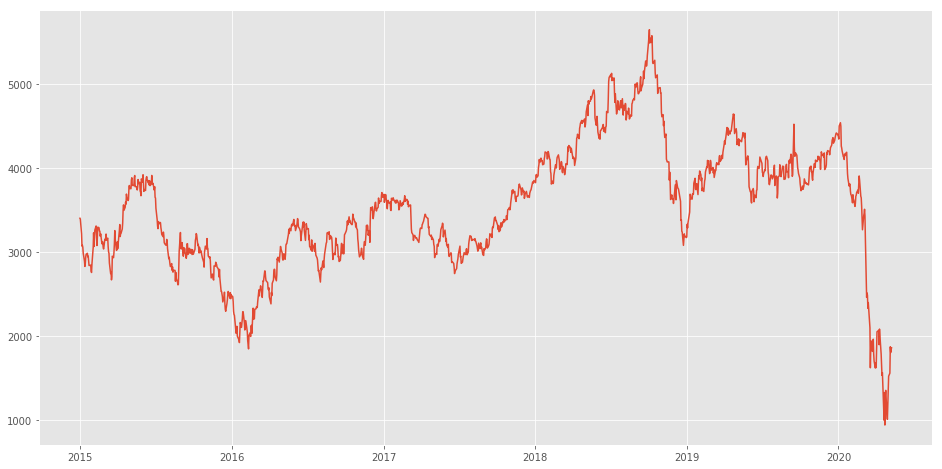

In [303]:
crude_df = preprocess_four(crude_df)
crude_df = preprocess_three(crude_df)
crude_df = preprocess_one(crude_df, 'Price')

K    1375
Name: Volume_unit, dtype: int64


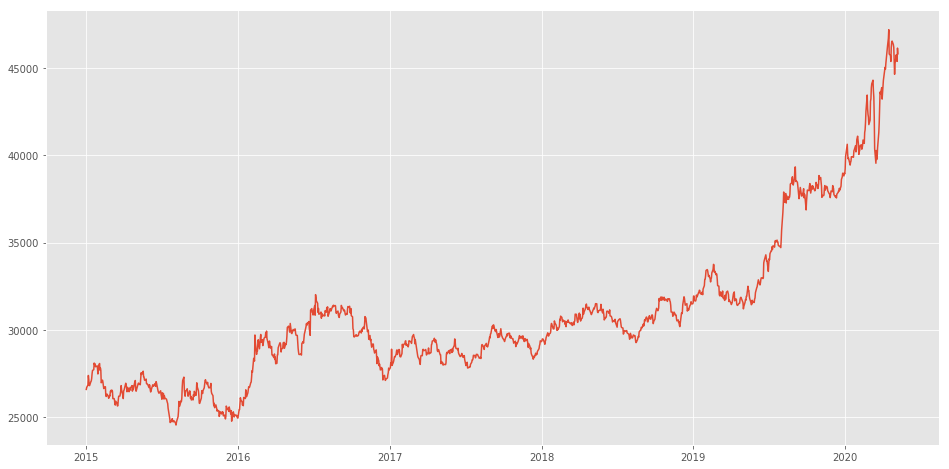

In [304]:
gold_df = preprocess_four(gold_df)
gold_df = preprocess_three(gold_df)
gold_df = preprocess_one(gold_df, 'Price')

K    1375
Name: Volume_unit, dtype: int64


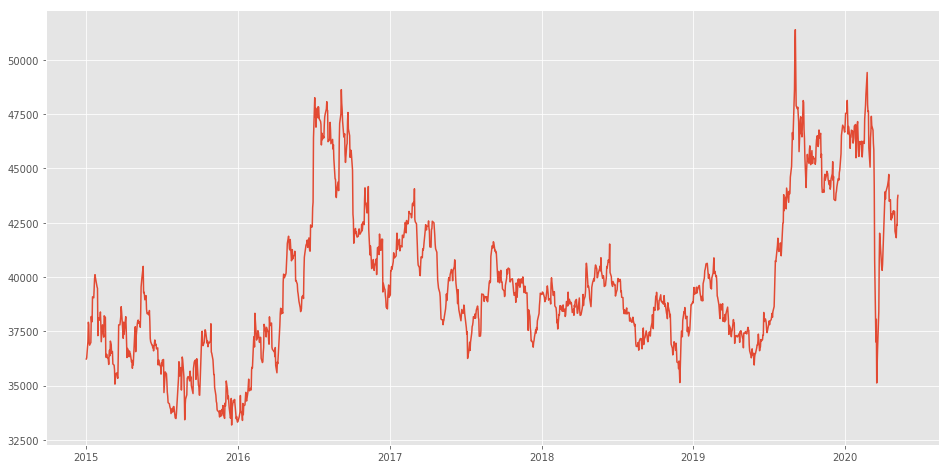

In [305]:
silver_df = preprocess_four(silver_df)
silver_df = preprocess_three(silver_df)
silver_df = preprocess_one(silver_df, 'Price')

K    1110
M     212
Name: Volume_unit, dtype: int64


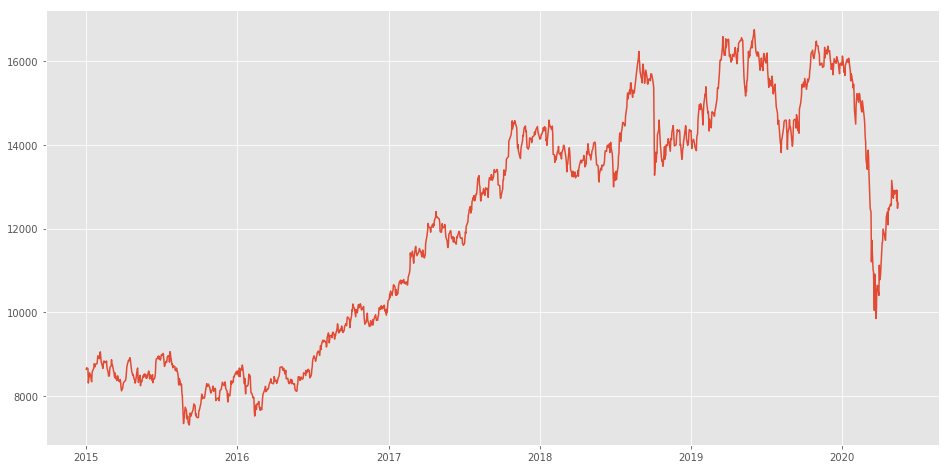

In [306]:
nse_sectoral_energy_df = preprocess_four(nse_sectoral_energy_df)
nse_sectoral_energy_df = preprocess_three(nse_sectoral_energy_df)
nse_sectoral_energy_df = preprocess_one(nse_sectoral_energy_df, 'Price')

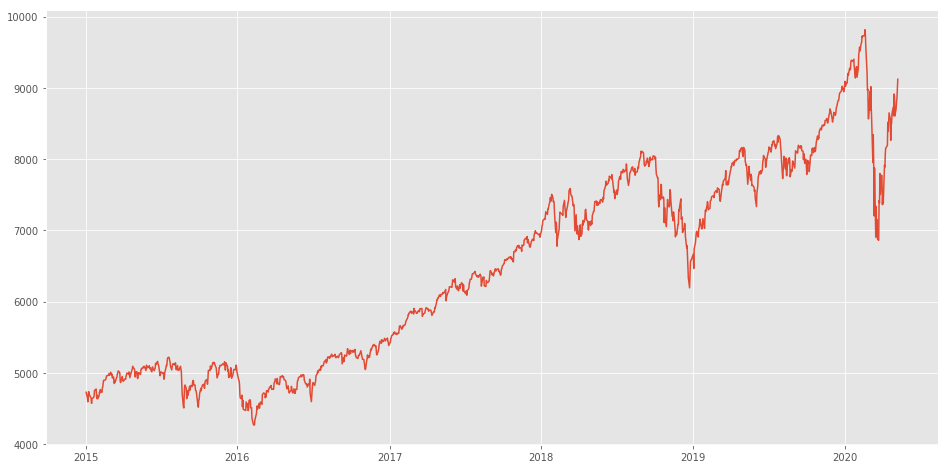

In [307]:
nasdaq_composite_df = preprocess_one(nasdaq_composite_df, 'Close')

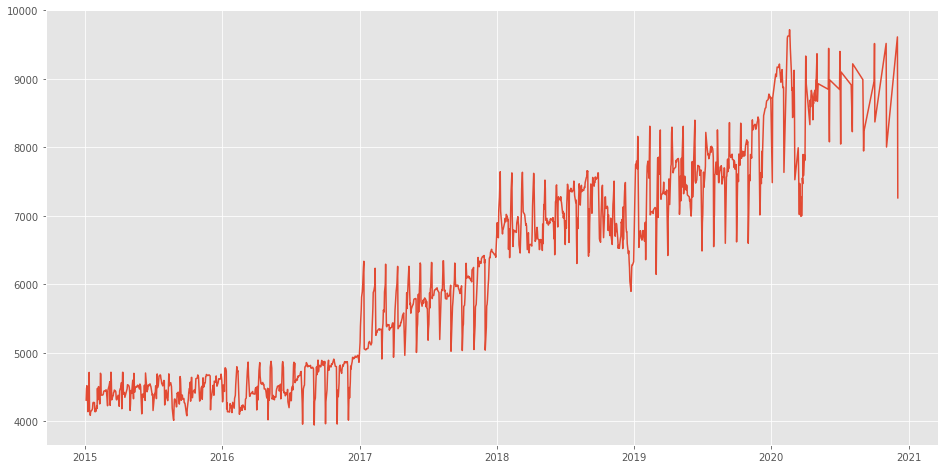

In [308]:
nasdaq_100_df = preprocess_one(nasdaq_100_df, 'Close')

In [309]:
print(nikkei_225_df.shape)
nikkei_225_df = nikkei_225_df[nikkei_225_df['Volume']!='0']
print(nikkei_225_df.shape)

(1333, 7)
(1304, 7)


M    624
B    508
K    172
Name: Volume_unit, dtype: int64


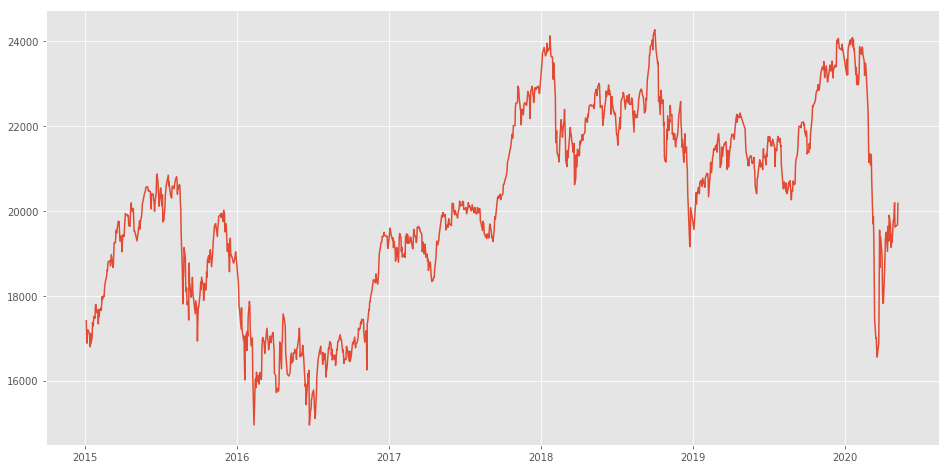

In [310]:
nikkei_225_df = preprocess_four(nikkei_225_df)
nikkei_225_df = preprocess_three(nikkei_225_df)
nikkei_225_df = preprocess_one(nikkei_225_df, 'Price')

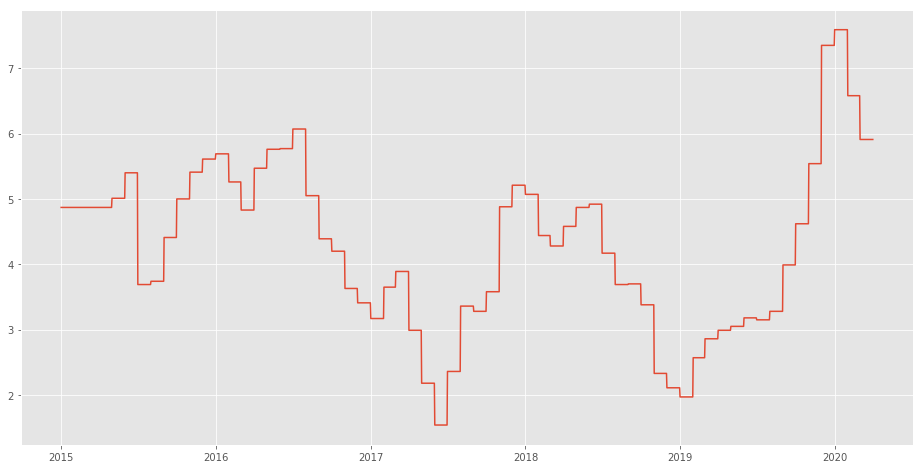

In [311]:
inflation_df = preprocess_one(inflation_df, 'InflationRate')

In [312]:
#Renaming columns in df
#Since the column names for each dataset is same, we are prefixing the dataset name to column names
#for better clarity

#all_stocks_df = all_stocks_df.add_prefix('stocks_')
nse_df = nse_df.add_prefix('nse_')
bse_df = bse_df.add_prefix('bse_')
crude_df = crude_df.add_prefix('crude_')
gold_df = gold_df.add_prefix('gold_')
silver_df = silver_df.add_prefix('silver_')

nse_sectoral_energy_df = nse_sectoral_energy_df.add_prefix('nse_sec_energy_')
nasdaq_composite_df = nasdaq_composite_df.add_prefix('nasdaqcomp_')
nasdaq_100_df = nasdaq_100_df.add_prefix('nasdaq100_')
nikkei_225_df = nikkei_225_df.add_prefix('nikkei_')

inflation_df = inflation_df.add_prefix('inflation_')

print(nse_df.shape, bse_df.shape, crude_df.shape, gold_df.shape, silver_df.shape, stock_df.shape, 
      nse_sectoral_energy_df.shape, nasdaq_composite_df.shape, nasdaq_100_df.shape, nikkei_225_df.shape
     ,inflation_df.shape)#, cipla_df.shape,
     #hdfc_df.shape, tm_df.shape, tcs_df.shape)

(1321, 7) (1320, 7) (1375, 7) (1375, 7) (1375, 7) (1314, 7) (1322, 7) (1347, 7) (1347, 7) (1304, 7) (1917, 2)


In [313]:
#Merge all individual data sets into one data set 
#the NSE Date is considered as the primary reference point for merging

joined_df = pd.merge(nse_df, bse_df, left_on='nse_Date', right_on='bse_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, crude_df, left_on='nse_Date', right_on='crude_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, gold_df, left_on='nse_Date', right_on='gold_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, silver_df, left_on='nse_Date', right_on='silver_Date', how='left')
print(joined_df.shape)


joined_df = pd.merge(joined_df, nse_sectoral_energy_df, left_on='nse_Date', right_on='nse_sec_energy_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, nasdaq_composite_df, left_on='nse_Date', right_on='nasdaqcomp_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, nasdaq_100_df, left_on='nse_Date', right_on='nasdaq100_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, nikkei_225_df, left_on='nse_Date', right_on='nikkei_Date', how='left')
print(joined_df.shape)

joined_df = pd.merge(joined_df, inflation_df, left_on='nse_Date', right_on='inflation_Date', how='left')
print(joined_df.shape)

joined_df.head(3)

(1321, 14)
(1321, 21)
(1321, 28)
(1321, 35)
(1321, 42)
(1321, 49)
(1321, 56)
(1321, 63)
(1321, 65)


nse_Date  nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
0 2015-01-01    8284.00   8272.80    8294.7  8248.75       56.56      0.02   
1 2015-01-02    8395.45   8288.70    8410.6  8288.70      101.89      1.35   
2 2015-01-05    8378.40   8407.95    8445.6  8363.90      118.16     -0.20   

    bse_Date  bse_Price  bse_Open  ...  nasdaq100_Volume  nikkei_Date  \
0 2015-01-01   27507.54  27485.77  ...               NaN          NaT   
1 2015-01-02   27887.90  27521.28  ...               NaN          NaT   
2 2015-01-05   27842.32  27978.43  ...      1.854400e+09   2015-01-05   

   nikkei_Price  nikkei_Open nikkei_High  nikkei_Low  nikkei_Volume  \
0           NaN          NaN         NaN         NaN            NaN   
1           NaN          NaN         NaN         NaN            NaN   
2      17408.71     17325.68    17540.92    17219.22        0.11646   

   nikkei_Chg%  inflation_Date  inflation_InflationRate  
0          NaN      2015-01-01                     4.87  
1          NaN      2015-01-02                     4.87  
2        -0.24      2015-01-05                     4.87  

[3 rows x 65 columns]

In [314]:
#concentrating only for one stock - reliance now

In [315]:
stock_all_df = pd.merge(joined_df, stock_df, left_on='nse_Date', right_on='Date', how='left')
print(stock_all_df.shape)

(1321, 72)


In [316]:
#Outer, missing in stocks? for all stocks?
stock_all_df[stock_all_df['Date'].isnull()]

nse_Date  nse_Price  nse_Open  nse_High   nse_Low  nse_Volume  \
40   2015-02-28    8901.85   8913.05   8941.10   8751.35      246.45   
214  2015-11-11    7825.00   7838.80   7847.95   7819.10      223.80   
451  2016-10-30    8625.70   8672.35   8678.25   8616.25      166.11   
1020 2019-02-13   10793.65  10870.55  10891.65  10772.10      321.96   
1050 2019-03-29   11623.90  11625.45  11630.35  11570.15      416.28   
1189 2019-10-27   11627.15  11662.25  11672.40  11604.60      161.78   
1257 2020-02-01   11661.85  11939.00  12017.35  11633.30      537.63   

      nse_Chg%   bse_Date  bse_Price  bse_Open  ...  nikkei_Chg%  \
40        0.65 2015-02-28   29361.50  29411.33  ...          NaN   
214       0.54 2015-11-11   25863.92  25934.90  ...         0.10   
451      -0.14 2016-10-30   27930.21  28066.32  ...          NaN   
1020     -0.35 2019-02-13   36034.11  36279.63  ...         1.34   
1050      0.47 2019-03-29   38672.91  38675.00  ...         0.82   
1189      0.37        NaT        NaN       NaN  ...          NaN   
1257     -2.51 2020-02-01   39735.53  40753.18  ...          NaN   

      inflation_Date  inflation_InflationRate  Date Open  High  Low  Close  \
40        2015-02-28                     4.87   NaT  NaN   NaN  NaN    NaN   
214       2015-11-11                     5.41   NaT  NaN   NaN  NaN    NaN   
451       2016-10-30                     4.20   NaT  NaN   NaN  NaN    NaN   
1020      2019-02-13                     2.57   NaT  NaN   NaN  NaN    NaN   
1050      2019-03-29                     2.86   NaT  NaN   NaN  NaN    NaN   
1189      2019-10-27                     4.62   NaT  NaN   NaN  NaN    NaN   
1257      2020-02-01                     6.58   NaT  NaN   NaN  NaN    NaN   

      Adj Close  Volume  
40          NaN     NaN  
214         NaN     NaN  
451         NaN     NaN  
1020        NaN     NaN  
1050        NaN     NaN  
1189        NaN     NaN  
1257        NaN     NaN  

[7 rows x 72 columns]

In [317]:
#delete these 7 rows
#these are weekends only, so can be deleted
stock_all_df.drop(stock_all_df[stock_all_df['Date'].isnull()].index, inplace = True)

In [318]:
print(stock_all_df.shape)

(1314, 72)


In [319]:
#remove repetative dates of each data set
#index based on date
stock_all_df.drop(['nse_Date','bse_Date','crude_Date', 'gold_Date', 'silver_Date'
                      ,'nse_sec_energy_Date','nasdaqcomp_Date', 'nasdaq100_Date', 'nikkei_Date', 'inflation_Date']
                     , axis=1, inplace=True)
stock_all_df.shape

(1314, 62)

In [320]:
stock_all_df.head(2)

nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  bse_Price  \
0    8284.00    8272.8    8294.7  8248.75       56.56      0.02   27507.54   
1    8395.45    8288.7    8410.6  8288.70      101.89      1.35   27887.90   

   bse_Open  bse_High   bse_Low  ...  nikkei_Volume  nikkei_Chg%  \
0  27485.77  27545.61  27395.34  ...            NaN          NaN   
1  27521.28  27937.47  27519.26  ...            NaN          NaN   

   inflation_InflationRate       Date        Open        High         Low  \
0                     4.87 2015-01-01  443.149994  446.000000  441.825012   
1                     4.87 2015-01-02  444.049988  448.024994  442.149994   

        Close   Adj Close     Volume  
0  443.950012  413.795502  1354878.0  
1  442.774994  412.700287  3351654.0  

[2 rows x 62 columns]

In [321]:
stock_all_df.set_index('Date', inplace=True)
stock_all_df.head(2)

nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
Date                                                                       
2015-01-01    8284.00    8272.8    8294.7  8248.75       56.56      0.02   
2015-01-02    8395.45    8288.7    8410.6  8288.70      101.89      1.35   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Low  \
Date                                                 ...               
2015-01-01   27507.54  27485.77  27545.61  27395.34  ...         NaN   
2015-01-02   27887.90  27521.28  27937.47  27519.26  ...         NaN   

            nikkei_Volume  nikkei_Chg%  inflation_InflationRate        Open  \
Date                                                                          
2015-01-01            NaN          NaN                     4.87  443.149994   
2015-01-02            NaN          NaN                     4.87  444.049988   

                  High         Low       Close   Adj Close     Volume  
Date                                                                   
2015-01-01  446.000000  441.825012  443.950012  413.795502  1354878.0  
2015-01-02  448.024994  442.149994  442.774994  412.700287  3351654.0  

[2 rows x 61 columns]

In [322]:
print(stock_all_df.shape)
stock_all_df.info()

(1314, 61)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1314 entries, 2015-01-01 to 2020-05-08
Data columns (total 61 columns):
nse_Price                  1314 non-null float64
nse_Open                   1314 non-null float64
nse_High                   1314 non-null float64
nse_Low                    1314 non-null float64
nse_Volume                 1314 non-null float64
nse_Chg%                   1314 non-null float32
bse_Price                  1314 non-null float64
bse_Open                   1314 non-null float64
bse_High                   1314 non-null float64
bse_Low                    1314 non-null float64
bse_Volume                 1314 non-null float64
bse_Chg%                   1314 non-null float32
crude_Price                1314 non-null float64
crude_Open                 1314 non-null float64
crude_High                 1314 non-null float64
crude_Low                  1314 non-null float64
crude_Volume               1314 non-null float64
crude_Chg%                 1314

# ARIMA

In [323]:
#TODO try multi variate time series arima

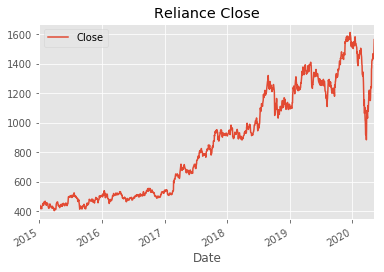

In [324]:
stock_all_df[['Close']].plot()
plt.title("Reliance Close")
plt.show()

Text(0.5, 1.0, 'Reliance Autocorrelation plot')

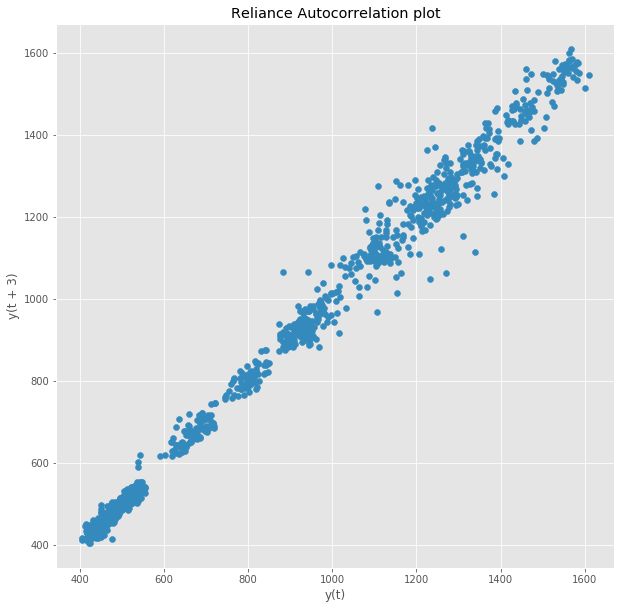

In [325]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10,10))
lag_plot(stock_all_df['Close'], lag=3)
plt.title('Reliance Autocorrelation plot')

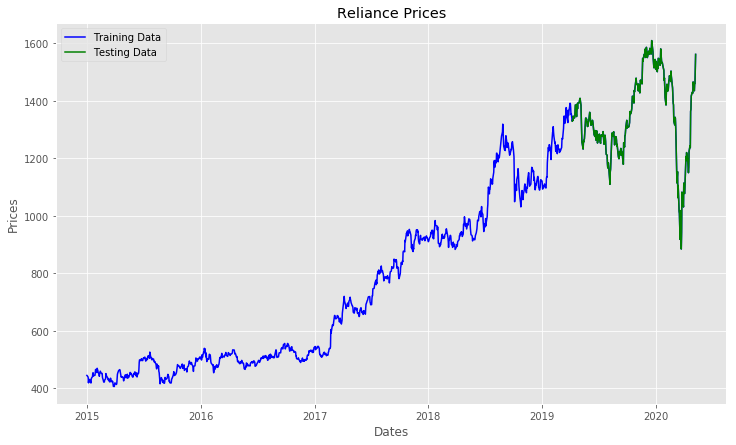

In [326]:
train_data, test_data = stock_all_df[0:int(len(stock_all_df)*0.8)], stock_all_df[int(len(stock_all_df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Reliance Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(stock_all_df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

In [327]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [328]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [329]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 1084.804
Symmetric mean absolute percentage error: 12.335


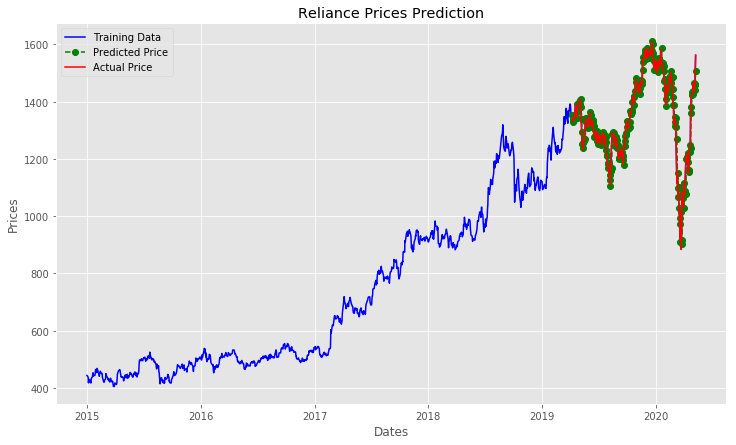

In [330]:
plt.figure(figsize=(12,7))
plt.plot(stock_all_df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Reliance Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()

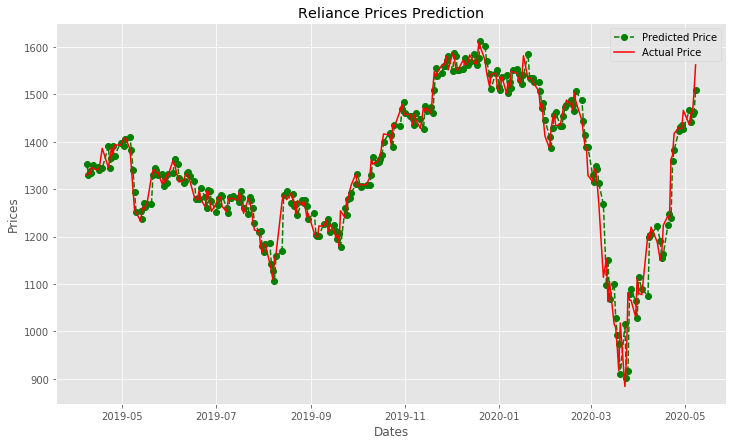

In [331]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
#plt.xticks(np.arange(1486,1856, 60), df['Date'][1486:1856:60])
plt.title('Reliance Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [332]:
#TODO 
#add moving average features
#up-sampling and interpolation for time series data

In [333]:
#Generate target variable for classification
#this is based on a threshold applied to stock close value

#creating new column (to generate y label) shifted date by 'n'  - 3 days
stock_all_df['shifted_close'] = stock_all_df[['Close']].shift(-3)
stock_all_df.head(5)

nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
Date                                                                       
2015-01-01    8284.00   8272.80   8294.70  8248.75       56.56      0.02   
2015-01-02    8395.45   8288.70   8410.60  8288.70      101.89      1.35   
2015-01-05    8378.40   8407.95   8445.60  8363.90      118.16     -0.20   
2015-01-06    8127.35   8325.30   8327.85  8111.35      172.80     -3.00   
2015-01-07    8102.10   8118.65   8151.20  8065.45      164.08     -0.31   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Volume  \
Date                                                 ...                  
2015-01-01   27507.54  27485.77  27545.61  27395.34  ...            NaN   
2015-01-02   27887.90  27521.28  27937.47  27519.26  ...            NaN   
2015-01-05   27842.32  27978.43  28064.49  27786.85  ...        0.11646   
2015-01-06   26987.46  27694.23  27698.93  26937.06  ...        0.16602   
2015-01-07   26908.82  26983.43  27051.60  26776.12  ...        0.13857   

            nikkei_Chg%  inflation_InflationRate        Open        High  \
Date                                                                       
2015-01-01          NaN                     4.87  443.149994  446.000000   
2015-01-02          NaN                     4.87  444.049988  448.024994   
2015-01-05        -0.24                     4.87  442.500000  445.450012   
2015-01-06        -3.02                     4.87  435.000000  436.500000   
2015-01-07         0.01                     4.87  418.549988  429.399994   

                   Low       Close   Adj Close     Volume  shifted_close  
Date                                                                      
2015-01-01  441.825012  443.950012  413.795502  1354878.0     418.049988  
2015-01-02  442.149994  442.774994  412.700287  3351654.0     427.149994  
2015-01-05  437.049988  437.924988  408.179718  4619182.0     421.024994  
2015-01-06  416.000000  418.049988  389.654694  8516086.0     430.149994  
2015-01-07  418.500000  427.149994  398.136597  9472630.0     425.149994  

[5 rows x 62 columns]

In [334]:
stock_all_df.tail(5)

nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
Date                                                                       
2020-05-04    9293.50   9533.50   9533.50  9266.95     0.68749     -5.74   
2020-05-05    9205.60   9429.40   9450.90  9190.75     0.72520     -0.95   
2020-05-06    9270.90   9226.80   9346.90  9116.50     0.72219      0.71   
2020-05-07    9199.05   9234.05   9277.85  9175.90     0.70874     -0.78   
2020-05-08    9251.50   9376.95   9382.65  9238.20     0.60905      0.57   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Volume  \
Date                                                 ...                  
2020-05-04   31715.35  32748.14  32748.14  31632.02  ...            NaN   
2020-05-05   31453.51  32182.90  32264.00  31403.57  ...            NaN   
2020-05-06   31685.75  31577.63  31970.84  31158.75  ...            NaN   
2020-05-07   31443.38  31677.69  31705.25  31362.87  ...         828.64   
2020-05-08   31642.70  32083.32  32088.51  31598.00  ...         822.09   

            nikkei_Chg%  inflation_InflationRate         Open         High  \
Date                                                                         
2020-05-04          NaN                      NaN  1440.000000  1465.000000   
2020-05-05          NaN                      NaN  1453.699951  1479.000000   
2020-05-06          NaN                      NaN  1464.000000  1484.949951   
2020-05-07         0.28                      NaN  1455.000000  1513.650024   
2020-05-08         2.56                      NaN  1545.000000  1579.900024   

                    Low        Close    Adj Close      Volume  shifted_close  
Date                                                                          
2020-05-04  1417.449951  1435.199951  1435.199951  24438682.0    1506.949951  
2020-05-05  1447.199951  1460.650024  1460.650024  20528490.0    1561.800049  
2020-05-06  1445.500000  1460.750000  1460.750000  18510252.0            NaN  
2020-05-07  1445.000000  1506.949951  1506.949951  22870646.0            NaN  
2020-05-08  1537.099976  1561.800049  1561.800049  38522104.0            NaN  

[5 rows x 62 columns]

In [335]:
#Based on the threshold and % bifference between close and 3 days shifted close , target is derived and categorized

In [336]:
#TO DO to be simplified
stock_all_df.loc[(((stock_all_df['shifted_close']-stock_all_df['Close'])/stock_all_df['Close'])*100)>3.0, 'target'] = 0
#stock_all_df.loc[((((stock_all_df['Close']-stock_all_df['shifted_close'])/stock_all_df['Close'])*100) >=0.0 and 
#                    (((stock_all_df['Close']-stock_all_df['shifted_close'])/stock_all_df['Close'])*100) <=3.0), 'target'] = 2
stock_all_df.loc[(((stock_all_df['shifted_close']-stock_all_df['Close'])/stock_all_df['Close'])*100)<0.0, 'target'] = 1

stock_all_df['target'].fillna(2.0, inplace=True)
print(stock_all_df.shape, '\n',stock_all_df['target'].value_counts())

(1314, 63) 
 1.0    601
2.0    520
0.0    193
Name: target, dtype: int64


In [337]:
#target 
# 0 is Buy - profit                              (T+3 is greater than T by more than 3% of T)
# 1 is Sell - loss # 1 is Buy - profit           (T+3 is lesser than T)
# 2 is Hold - no loss/gain # 1 is Buy - profit   (T+3 is between 1 and 3 categories compared to T)

stock_all_df.drop(columns=['Close'], inplace=True)
stock_all_df.drop(columns=['Adj Close'], inplace=True)
print(stock_all_df.shape)
stock_all_df.head(5)

(1314, 61)


nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
Date                                                                       
2015-01-01    8284.00   8272.80   8294.70  8248.75       56.56      0.02   
2015-01-02    8395.45   8288.70   8410.60  8288.70      101.89      1.35   
2015-01-05    8378.40   8407.95   8445.60  8363.90      118.16     -0.20   
2015-01-06    8127.35   8325.30   8327.85  8111.35      172.80     -3.00   
2015-01-07    8102.10   8118.65   8151.20  8065.45      164.08     -0.31   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Low  \
Date                                                 ...               
2015-01-01   27507.54  27485.77  27545.61  27395.34  ...         NaN   
2015-01-02   27887.90  27521.28  27937.47  27519.26  ...         NaN   
2015-01-05   27842.32  27978.43  28064.49  27786.85  ...    17219.22   
2015-01-06   26987.46  27694.23  27698.93  26937.06  ...    16881.73   
2015-01-07   26908.82  26983.43  27051.60  26776.12  ...    16808.26   

            nikkei_Volume  nikkei_Chg%  inflation_InflationRate        Open  \
Date                                                                          
2015-01-01            NaN          NaN                     4.87  443.149994   
2015-01-02            NaN          NaN                     4.87  444.049988   
2015-01-05        0.11646        -0.24                     4.87  442.500000   
2015-01-06        0.16602        -3.02                     4.87  435.000000   
2015-01-07        0.13857         0.01                     4.87  418.549988   

                  High         Low     Volume  shifted_close  target  
Date                                                                  
2015-01-01  446.000000  441.825012  1354878.0     418.049988     1.0  
2015-01-02  448.024994  442.149994  3351654.0     427.149994     1.0  
2015-01-05  445.450012  437.049988  4619182.0     421.024994     1.0  
2015-01-06  436.500000  416.000000  8516086.0     430.149994     2.0  
2015-01-07  429.399994  418.500000  9472630.0     425.149994     1.0  

[5 rows x 61 columns]

In [338]:
stock_all_df.tail(5)

nse_Price  nse_Open  nse_High  nse_Low  nse_Volume  nse_Chg%  \
Date                                                                       
2020-05-04    9293.50   9533.50   9533.50  9266.95     0.68749     -5.74   
2020-05-05    9205.60   9429.40   9450.90  9190.75     0.72520     -0.95   
2020-05-06    9270.90   9226.80   9346.90  9116.50     0.72219      0.71   
2020-05-07    9199.05   9234.05   9277.85  9175.90     0.70874     -0.78   
2020-05-08    9251.50   9376.95   9382.65  9238.20     0.60905      0.57   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Low  \
Date                                                 ...               
2020-05-04   31715.35  32748.14  32748.14  31632.02  ...         NaN   
2020-05-05   31453.51  32182.90  32264.00  31403.57  ...         NaN   
2020-05-06   31685.75  31577.63  31970.84  31158.75  ...         NaN   
2020-05-07   31443.38  31677.69  31705.25  31362.87  ...    19448.93   
2020-05-08   31642.70  32083.32  32088.51  31598.00  ...    19894.58   

            nikkei_Volume  nikkei_Chg%  inflation_InflationRate         Open  \
Date                                                                           
2020-05-04            NaN          NaN                      NaN  1440.000000   
2020-05-05            NaN          NaN                      NaN  1453.699951   
2020-05-06            NaN          NaN                      NaN  1464.000000   
2020-05-07         828.64         0.28                      NaN  1455.000000   
2020-05-08         822.09         2.56                      NaN  1545.000000   

                   High          Low      Volume  shifted_close  target  
Date                                                                     
2020-05-04  1465.000000  1417.449951  24438682.0    1506.949951     0.0  
2020-05-05  1479.000000  1447.199951  20528490.0    1561.800049     0.0  
2020-05-06  1484.949951  1445.500000  18510252.0            NaN     2.0  
2020-05-07  1513.650024  1445.000000  22870646.0            NaN     2.0  
2020-05-08  1579.900024  1537.099976  38522104.0            NaN     2.0  

[5 rows x 61 columns]

In [339]:
#Check are there any nulls

null_columns = stock_all_df.columns[stock_all_df.isnull().any()]
stock_all_df[null_columns].isnull().sum()

nse_sec_energy_Price         1
nse_sec_energy_Open          1
nse_sec_energy_High          1
nse_sec_energy_Low           1
nse_sec_energy_Volume        1
nse_sec_energy_Chg%          1
nasdaqcomp_Open             38
nasdaqcomp_High             38
nasdaqcomp_Low              38
nasdaqcomp_Close            38
nasdaqcomp_Adj Close        38
nasdaqcomp_Volume           38
nasdaq100_Open             192
nasdaq100_High             192
nasdaq100_Low              192
nasdaq100_Close            192
nasdaq100_Adj Close        192
nasdaq100_Volume           192
nikkei_Price                88
nikkei_Open                 88
nikkei_High                 88
nikkei_Low                  88
nikkei_Volume               88
nikkei_Chg%                 88
inflation_InflationRate     23
shifted_close                3
dtype: int64

In [340]:
#More TODO
#Need to add more features like
# nse sectoral close values for stock
# 3/5/7/n days close's moving average column instead if close directly 

# Train test

In [341]:
#Lets take 2015-01-01 to 2018-12-31 as train set
#And use 2019-01-01 to 2019-12-31 as validation set

In [342]:
#since this is timeseries we can do test prediction for next few days 2020-01-02, 03 and 06

In [343]:
#TODO
#Build better model OR need better approach
#Doing something incorrect - to check

#Model with just close and shifted close is better than rest of the features being used

In [344]:
#TODO
#remove least important/non-contributing features
#Hyperparameter tuning, grid/random search

In [345]:
#Using 2015 start to 2019 end as our complete date range
stock_all_df = stock_all_df.loc['2015-01-01':'2019-12-31']

In [346]:
null_columns = stock_all_df.columns[stock_all_df.isnull().any()]
stock_all_df[null_columns].isnull().sum()

nse_sec_energy_Price       1
nse_sec_energy_Open        1
nse_sec_energy_High        1
nse_sec_energy_Low         1
nse_sec_energy_Volume      1
nse_sec_energy_Chg%        1
nasdaqcomp_Open           35
nasdaqcomp_High           35
nasdaqcomp_Low            35
nasdaqcomp_Close          35
nasdaqcomp_Adj Close      35
nasdaqcomp_Volume         35
nasdaq100_Open           163
nasdaq100_High           163
nasdaq100_Low            163
nasdaq100_Close          163
nasdaq100_Adj Close      163
nasdaq100_Volume         163
nikkei_Price              77
nikkei_Open               77
nikkei_High               77
nikkei_Low                77
nikkei_Volume             77
nikkei_Chg%               77
dtype: int64

In [347]:
stock_all_df[stock_all_df["nse_sec_energy_Price"].isnull()]

nse_Price  nse_Open  nse_High   nse_Low  nse_Volume  nse_Chg%  \
Date                                                                        
2017-10-19   10146.55  10210.35  10211.95  10123.35       31.09     -0.63   

            bse_Price  bse_Open  bse_High   bse_Low  ...  nikkei_Low  \
Date                                                 ...               
2017-10-19   32572.93  32656.75  32663.06  32533.89  ...    21381.52   

            nikkei_Volume  nikkei_Chg%  inflation_InflationRate        Open  \
Date                                                                          
2017-10-19         872.21          0.4                     3.58  915.799988   

                  High    Low     Volume  shifted_close  target  
Date                                                             
2017-10-19  921.900024  903.0  3664082.0     939.900024     0.0  

[1 rows x 61 columns]

In [348]:
stock_all_df.fillna(0, inplace=True)

In [349]:
null_columns = stock_all_df.columns[stock_all_df.isnull().any()]
stock_all_df[null_columns].isnull().sum()

Series([], dtype: float64)

# EDA

In [350]:
stock_all_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1228 entries, 2015-01-01 to 2019-12-31
Data columns (total 61 columns):
nse_Price                  1228 non-null float64
nse_Open                   1228 non-null float64
nse_High                   1228 non-null float64
nse_Low                    1228 non-null float64
nse_Volume                 1228 non-null float64
nse_Chg%                   1228 non-null float32
bse_Price                  1228 non-null float64
bse_Open                   1228 non-null float64
bse_High                   1228 non-null float64
bse_Low                    1228 non-null float64
bse_Volume                 1228 non-null float64
bse_Chg%                   1228 non-null float32
crude_Price                1228 non-null float64
crude_Open                 1228 non-null float64
crude_High                 1228 non-null float64
crude_Low                  1228 non-null float64
crude_Volume               1228 non-null float64
crude_Chg%                 1228 non-null f

In [351]:
stock_all_df_copy = stock_all_df.copy()
print(stock_all_df.shape, stock_all_df_copy.shape)

(1228, 61) (1228, 61)


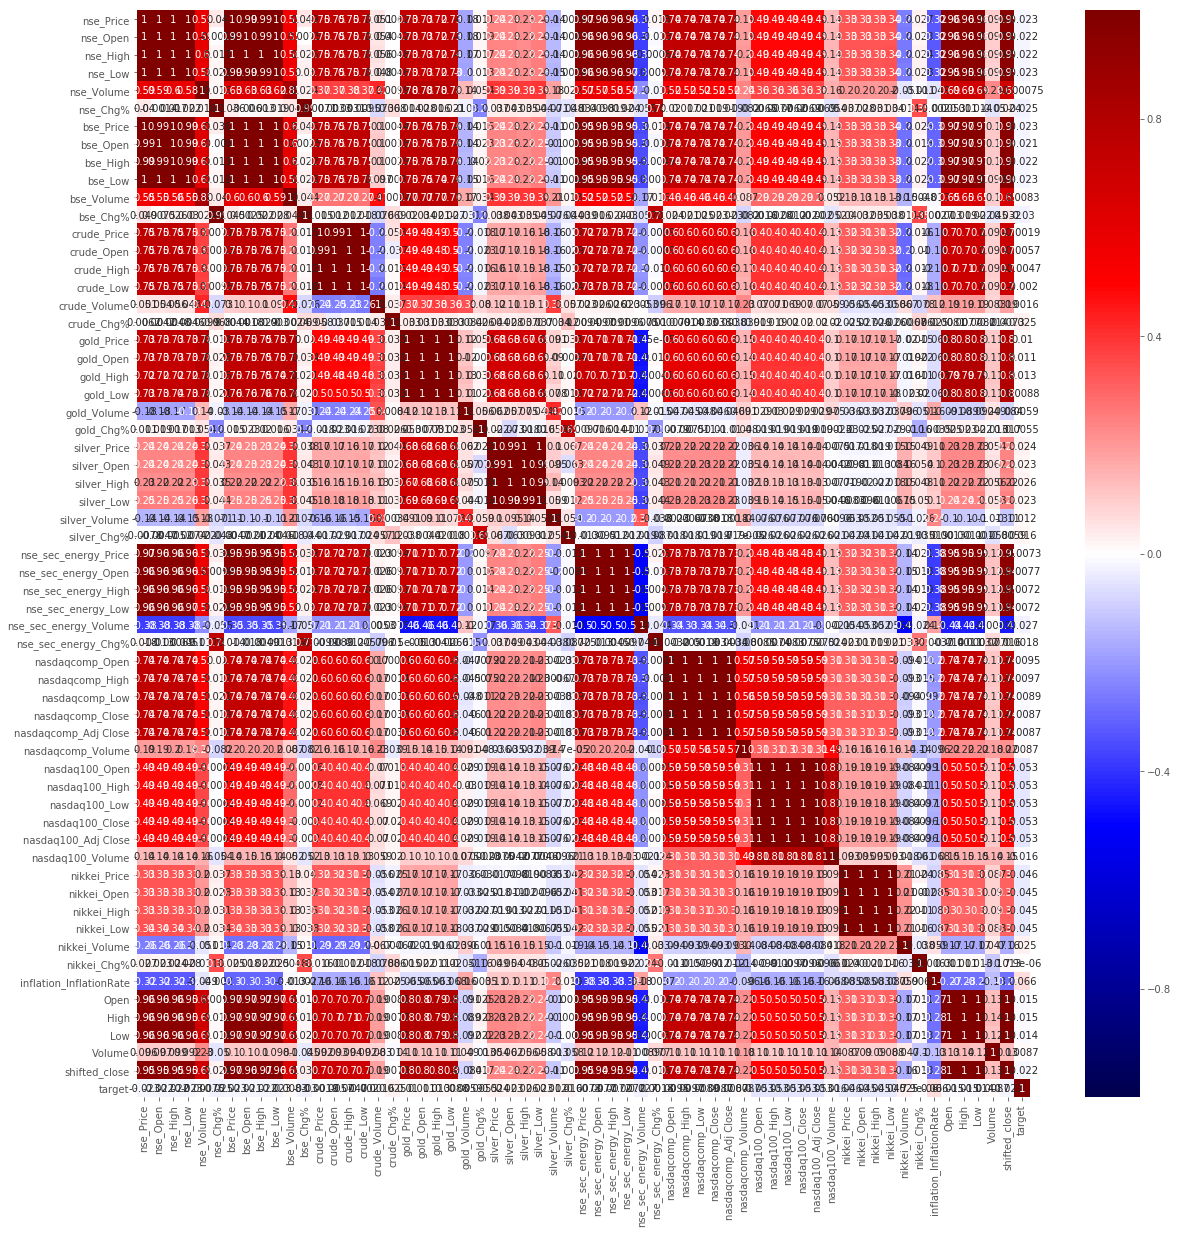

In [352]:
#Heat Map - Correlation
corr = stock_all_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap='seismic', annot=True, vmin=-1,vmax=1)

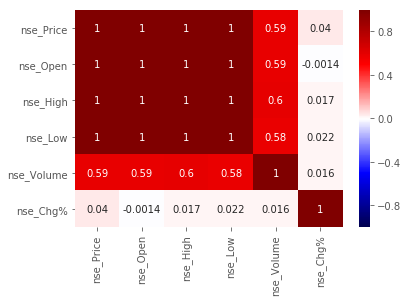

In [353]:
sns.heatmap(stock_all_df.iloc[:,0:6].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [354]:
cols_to_drop = []
cols_to_drop.append('nse_Open')
cols_to_drop.append('nse_High')
cols_to_drop.append('nse_Low')

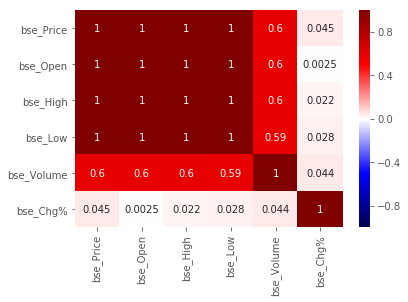

In [355]:
sns.heatmap(stock_all_df.iloc[:,6:12].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [356]:
cols_to_drop.append('bse_Open')
cols_to_drop.append('bse_High')
cols_to_drop.append('bse_Low')

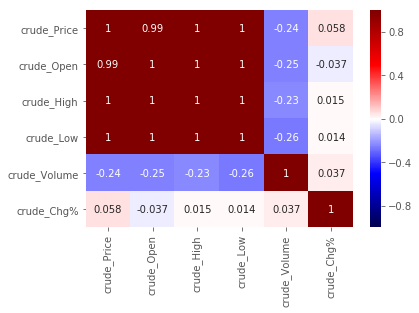

In [357]:
sns.heatmap(stock_all_df.iloc[:,12:18].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [358]:
cols_to_drop.append('crude_Open')
cols_to_drop.append('crude_High')
cols_to_drop.append('crude_Low')

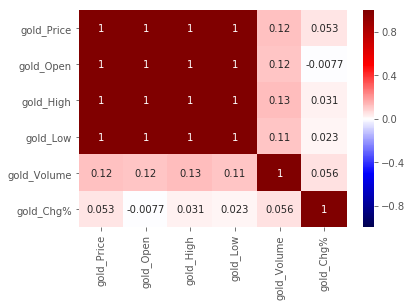

In [359]:
sns.heatmap(stock_all_df.iloc[:,18:24].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [360]:
cols_to_drop.append('gold_Open')
cols_to_drop.append('gold_High')
cols_to_drop.append('gold_Low')

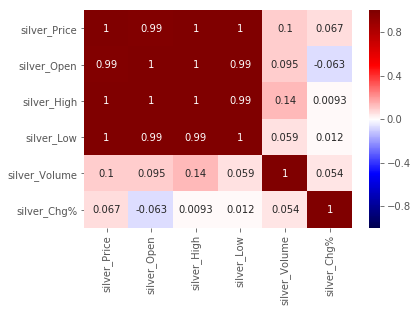

In [361]:
sns.heatmap(stock_all_df.iloc[:,24:30].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [362]:
cols_to_drop.append('silver_Open')
cols_to_drop.append('silver_High')
cols_to_drop.append('silver_Low')

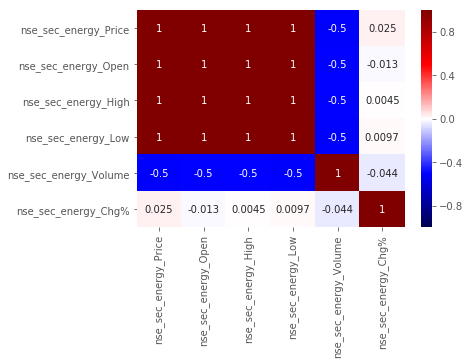

In [363]:
sns.heatmap(stock_all_df.iloc[:,30:36].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [364]:
cols_to_drop.append('nse_sec_energy_Open')
cols_to_drop.append('nse_sec_energy_High')
cols_to_drop.append('nse_sec_energy_Low')

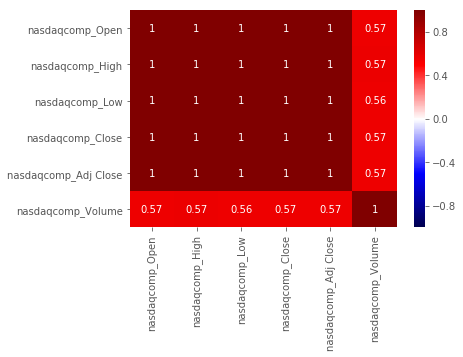

In [365]:
sns.heatmap(stock_all_df.iloc[:,36:42].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [366]:
cols_to_drop.append('nasdaqcomp_Open')
cols_to_drop.append('nasdaqcomp_High')
cols_to_drop.append('nasdaqcomp_Low')
cols_to_drop.append('nasdaqcomp_Close')

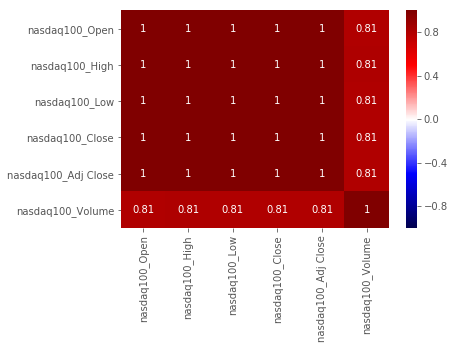

In [367]:
sns.heatmap(stock_all_df.iloc[:,42:48].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [368]:
cols_to_drop.append('nasdaq100_Open')
cols_to_drop.append('nasdaq100_High')
cols_to_drop.append('nasdaq100_Low')
cols_to_drop.append('nasdaq100_Close')
cols_to_drop.append('nasdaq100_Volume')

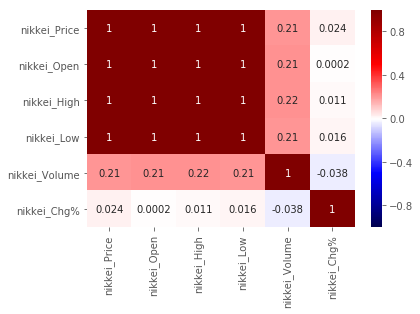

In [369]:
sns.heatmap(stock_all_df.iloc[:,48:54].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [370]:
cols_to_drop.append('nikkei_Open')
cols_to_drop.append('nikkei_High')
cols_to_drop.append('nikkei_Low')
cols_to_drop.append('nikkei_Price')

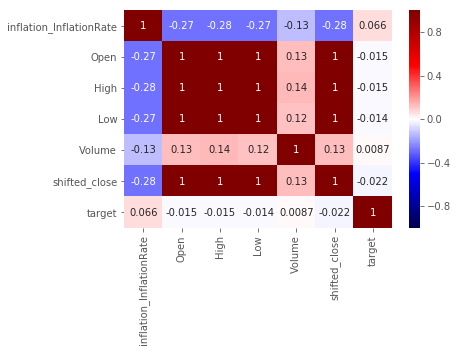

In [371]:
sns.heatmap(stock_all_df.iloc[:,54:].corr(),cmap='seismic', annot=True, vmin=-1,vmax=1)

In [372]:
cols_to_drop.append('Open')
cols_to_drop.append('High')
cols_to_drop.append('Low')

In [373]:
cols_to_drop

['nse_Open',
 'nse_High',
 'nse_Low',
 'bse_Open',
 'bse_High',
 'bse_Low',
 'crude_Open',
 'crude_High',
 'crude_Low',
 'gold_Open',
 'gold_High',
 'gold_Low',
 'silver_Open',
 'silver_High',
 'silver_Low',
 'nse_sec_energy_Open',
 'nse_sec_energy_High',
 'nse_sec_energy_Low',
 'nasdaqcomp_Open',
 'nasdaqcomp_High',
 'nasdaqcomp_Low',
 'nasdaqcomp_Close',
 'nasdaq100_Open',
 'nasdaq100_High',
 'nasdaq100_Low',
 'nasdaq100_Close',
 'nasdaq100_Volume',
 'nikkei_Open',
 'nikkei_High',
 'nikkei_Low',
 'nikkei_Price',
 'Open',
 'High',
 'Low']

In [374]:
#Beause of multi collinearity, we can just have only nse_Price
stock_all_df.drop(columns=cols_to_drop, inplace=True)

In [375]:
print(stock_all_df.shape)

(1228, 27)


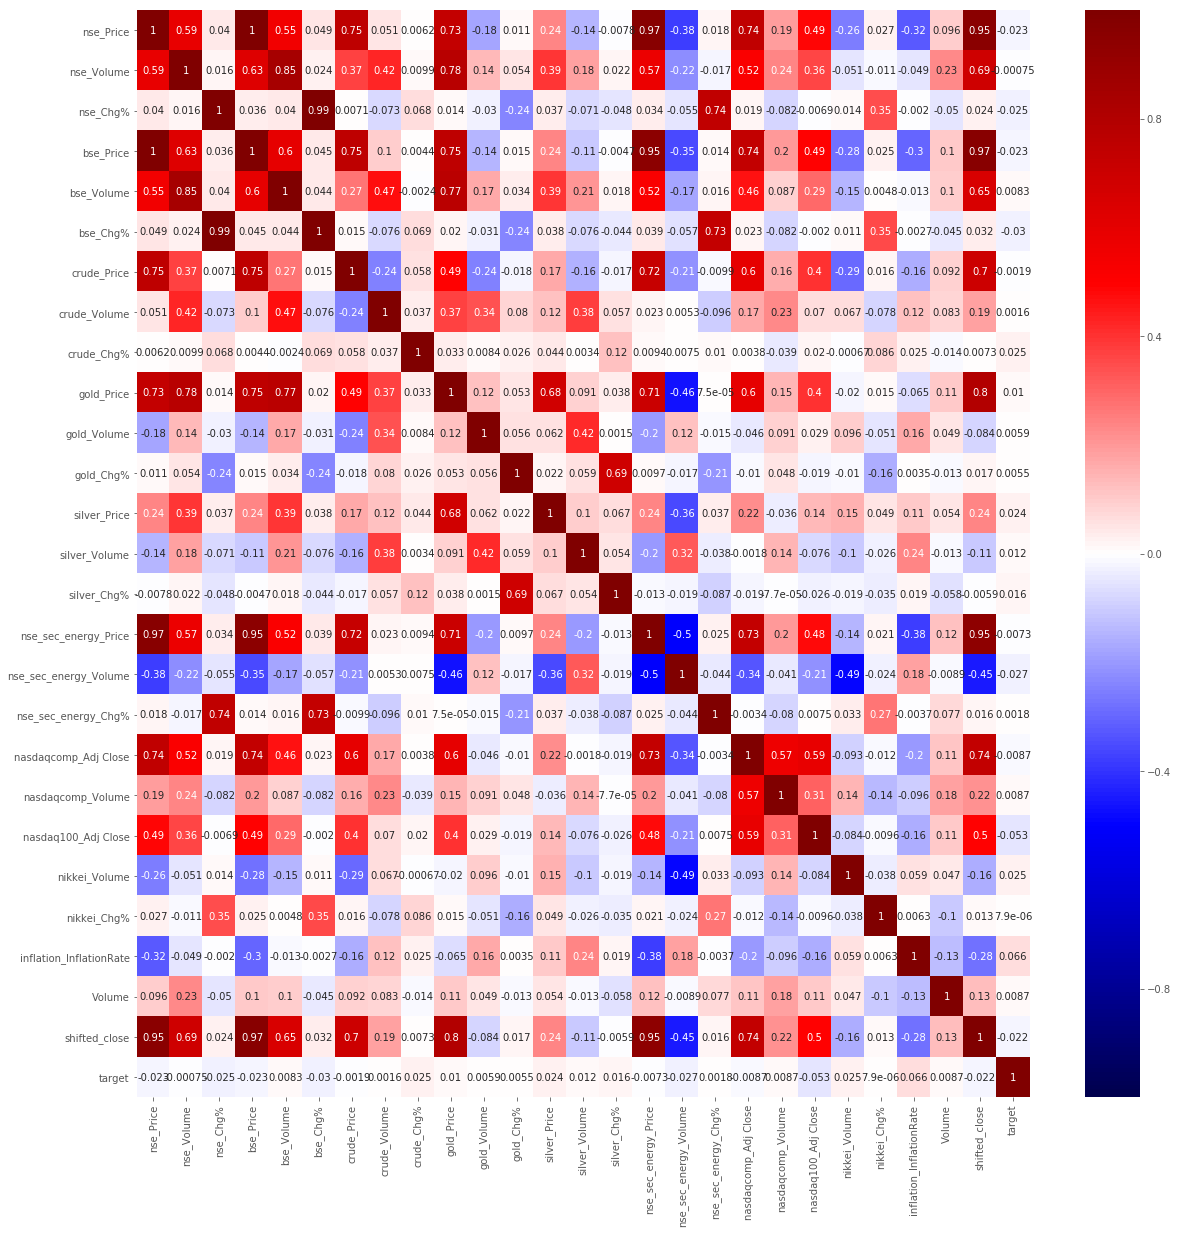

In [376]:
#Heat Map - Correlation
corr = stock_all_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap='seismic', annot=True, vmin=-1,vmax=1)

In [377]:
#Used >0.8 corr as the cutoff

#Beause of multi collinearity again
# we can keep nse_Price and drop bse_Price and nse_sec_energy_Price
stock_all_df.drop(columns=['nse_Price','bse_Price','nse_sec_energy_Price'], inplace=True)

# we can keep nse_Volume, nse_Chg% and drop bse_Volume, bse_Chg%
stock_all_df.drop(columns=['bse_Volume','bse_Chg%'], inplace=True)

In [378]:
stock_all_df.shape

(1228, 22)

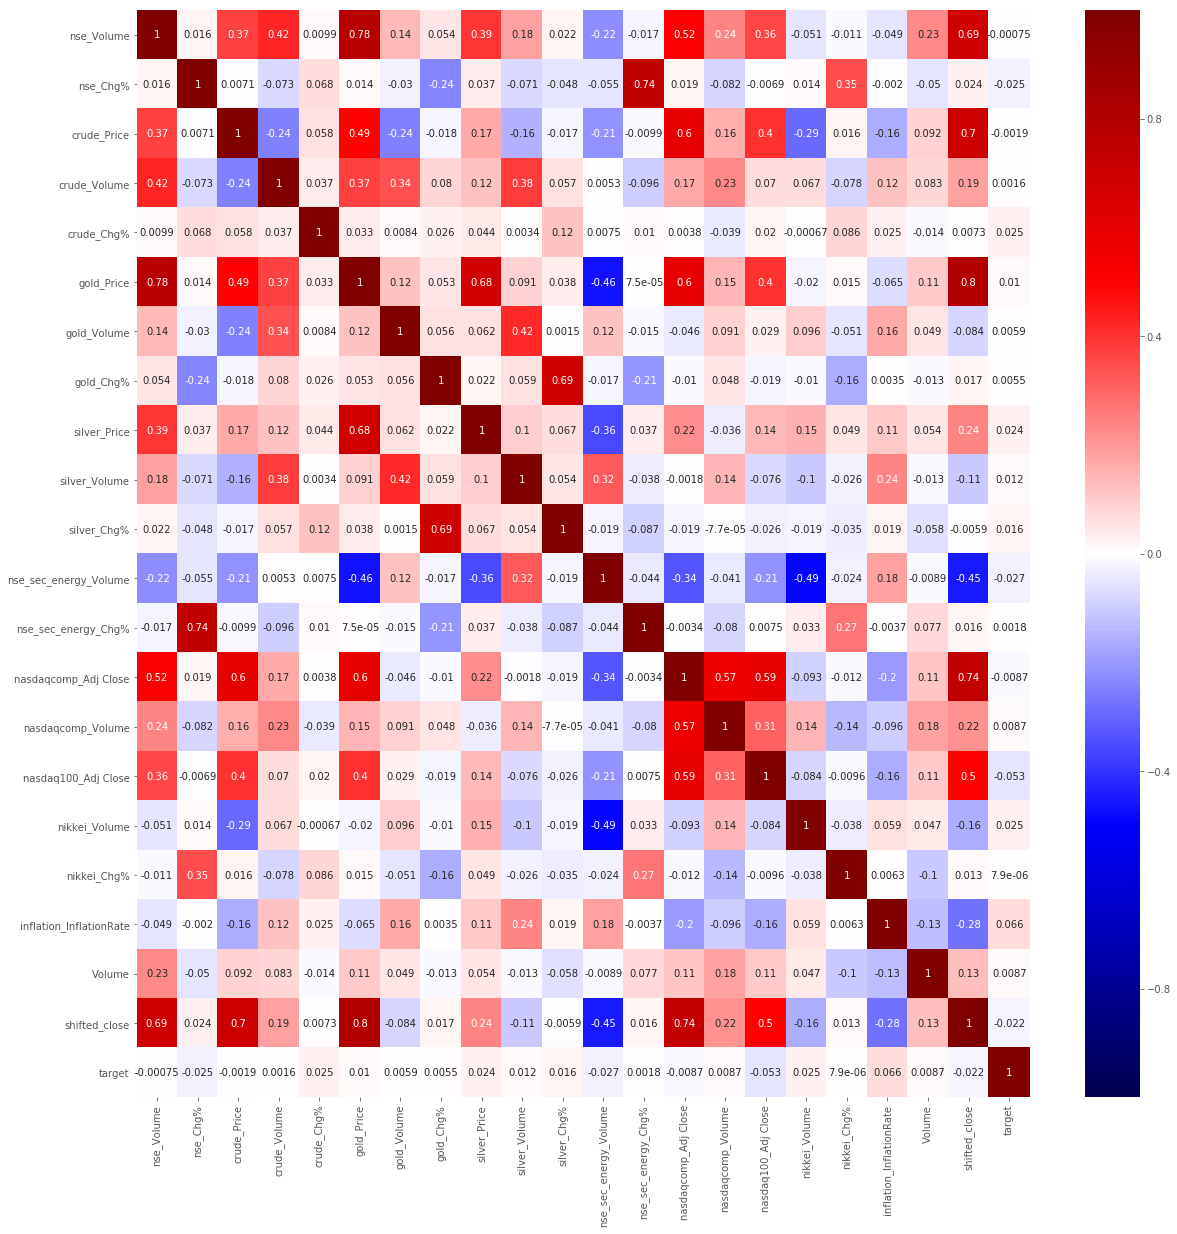

In [379]:
#Heat Map - Correlation
corr = stock_all_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap='seismic', annot=True, vmin=-1,vmax=1)

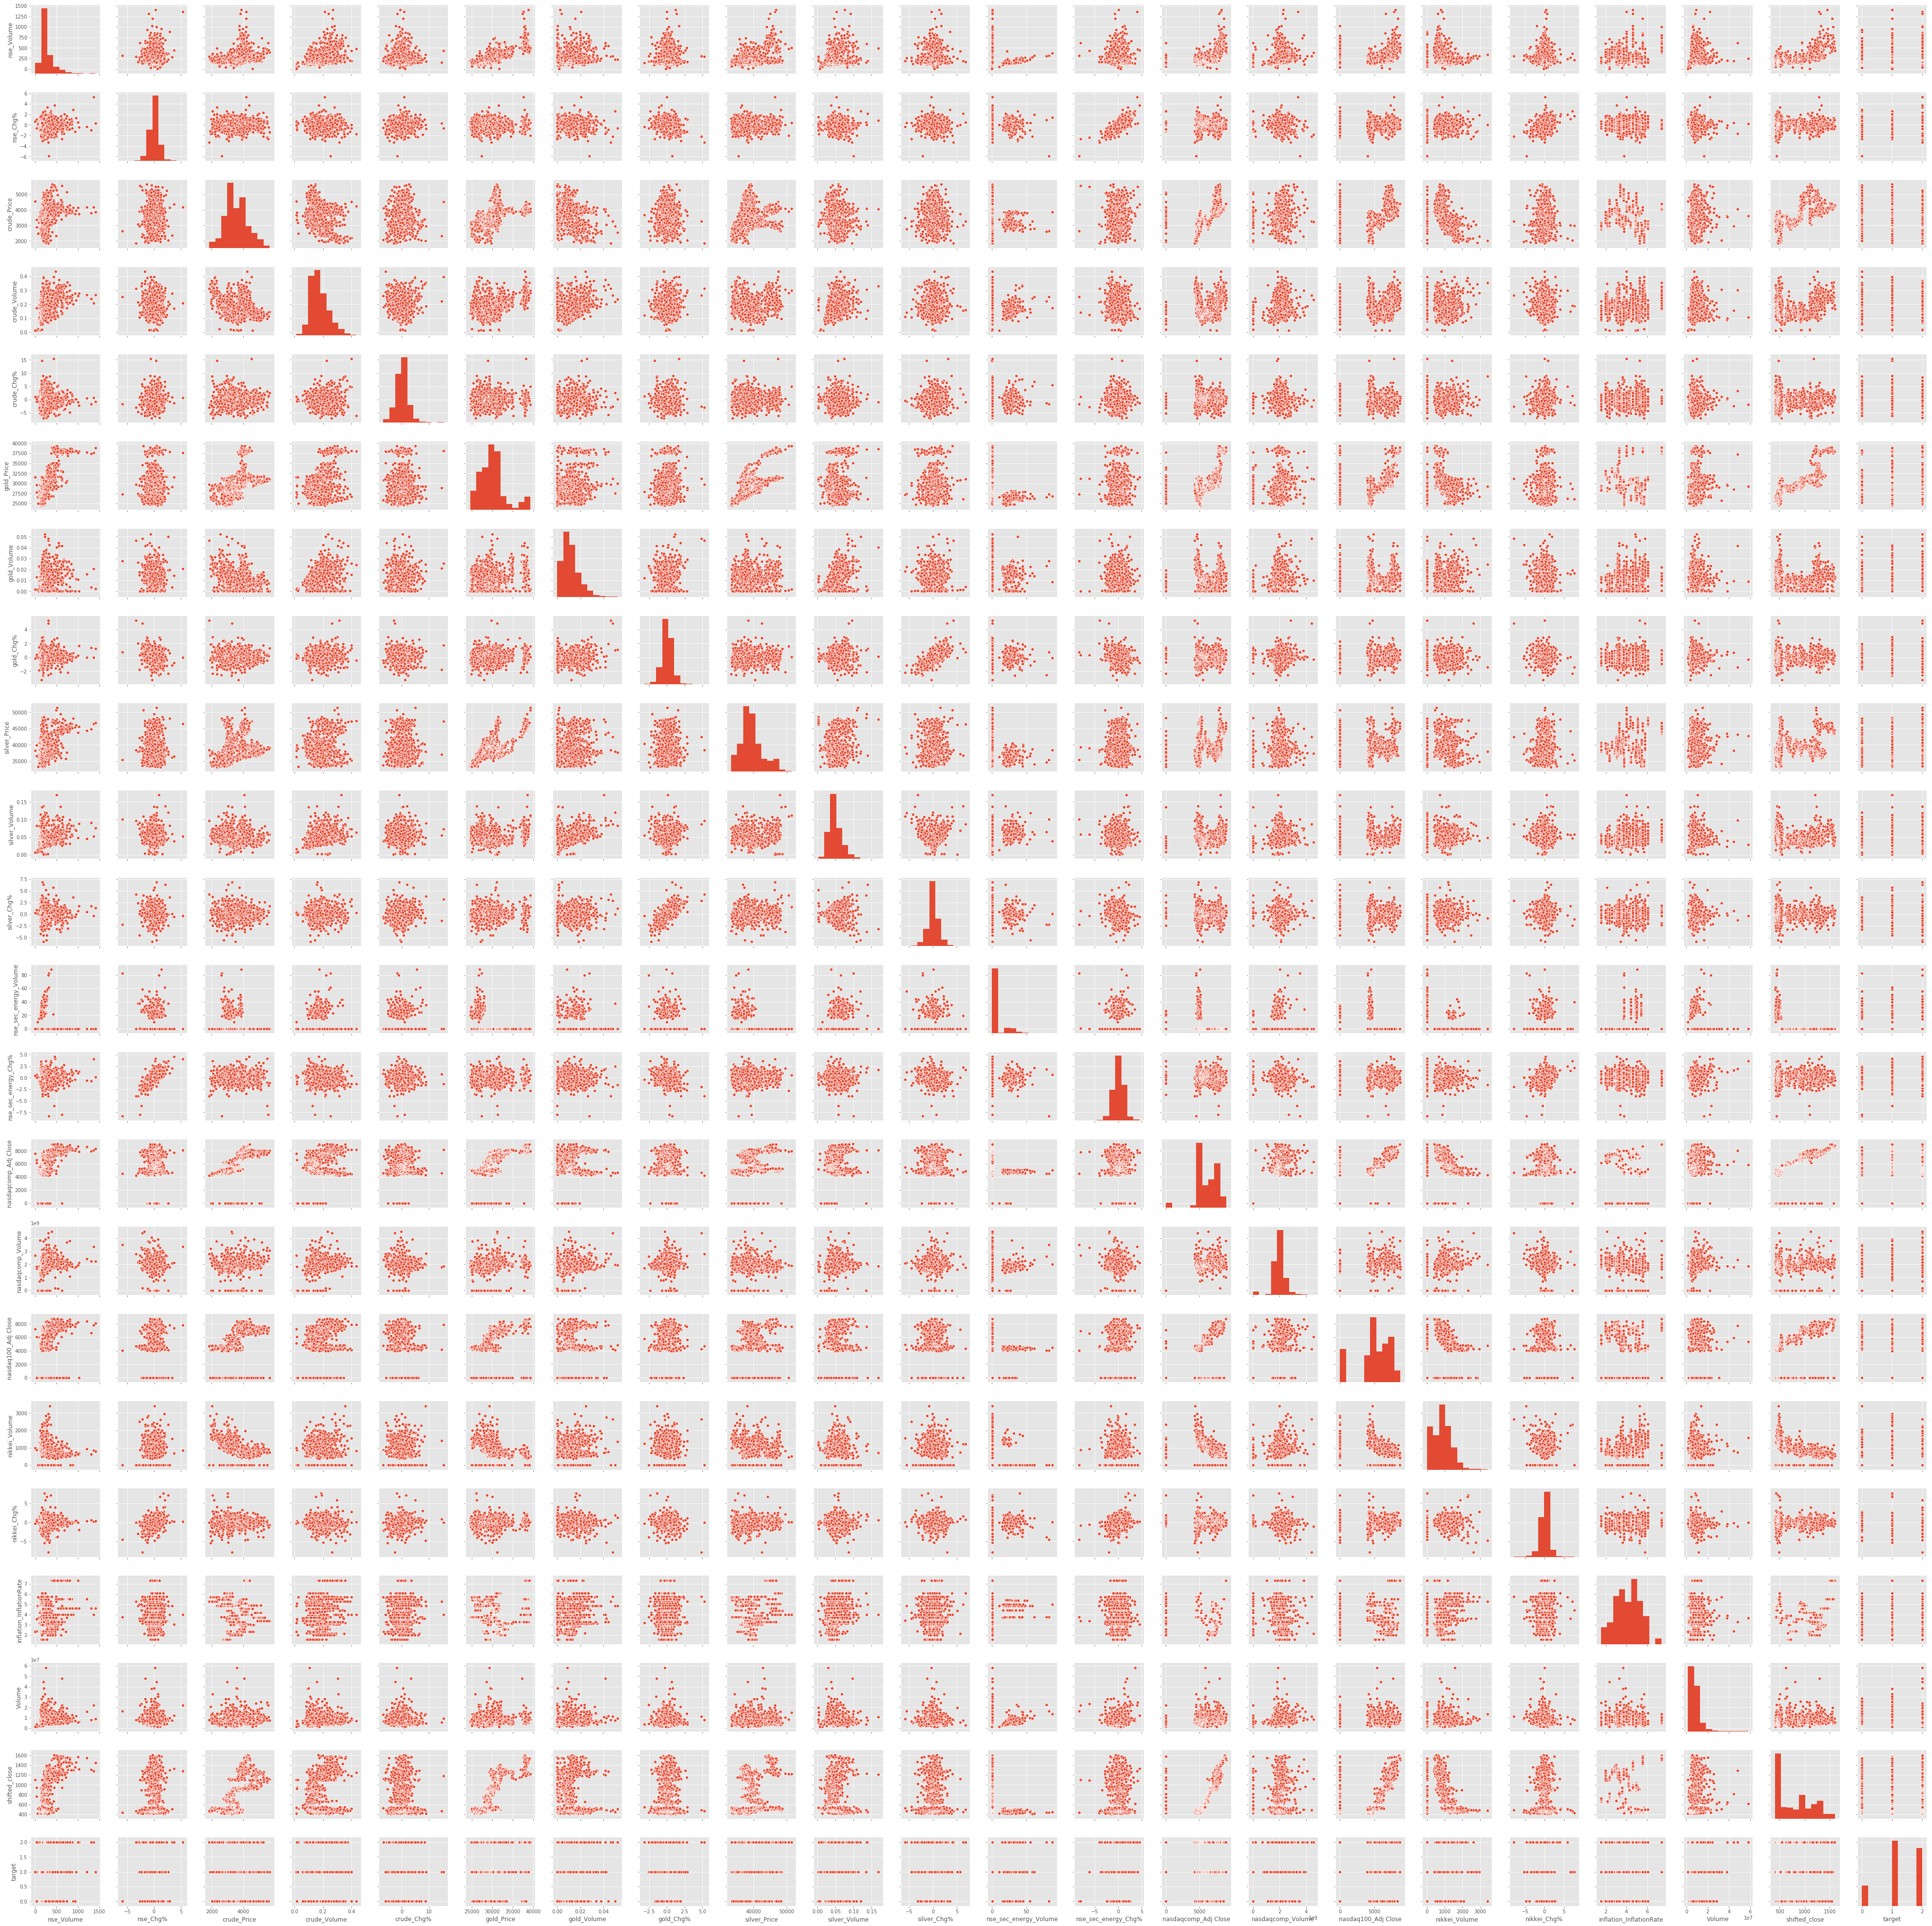

In [380]:
# Pairplot using sns
#NSE BSE Target
sns.pairplot(stock_all_df)

In [381]:
#groups like nse, bse,,,, are very correlated within their columns
#so instead of having high, low, open, close, vol, cgh - we have one/few per group
#with target, high corr are stock's close, mostly all features does not have direct/explicit relation displayed

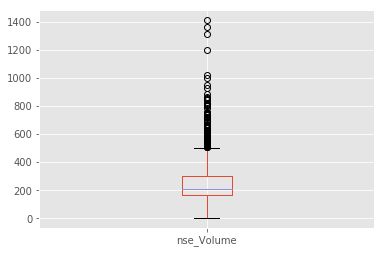

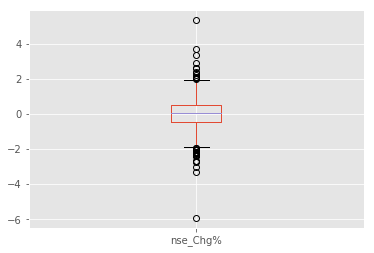

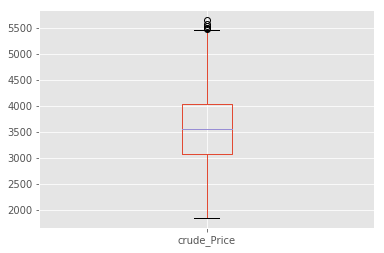

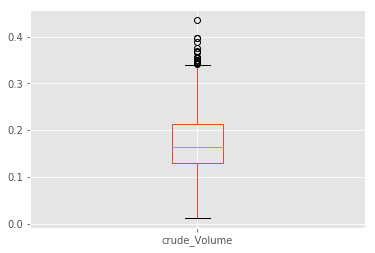

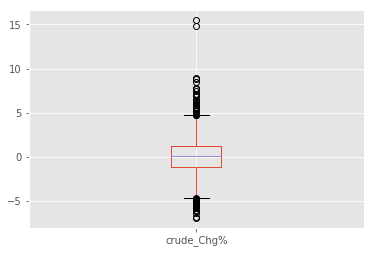

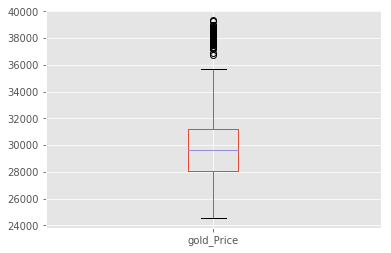

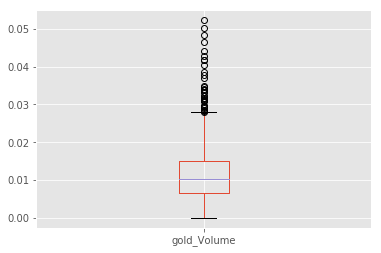

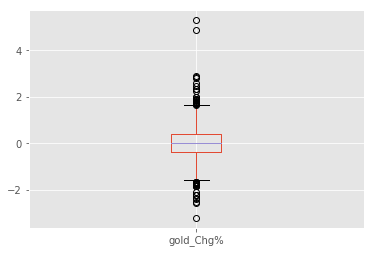

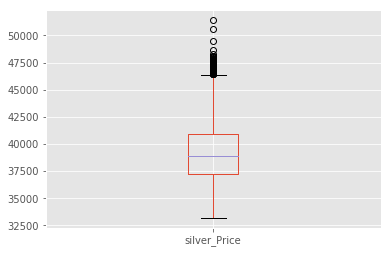

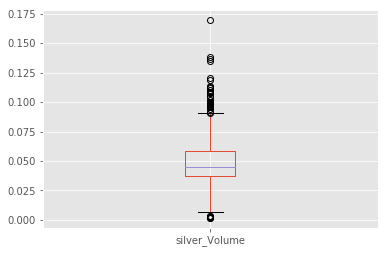

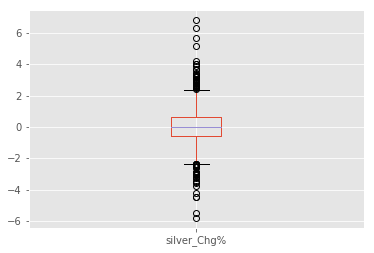

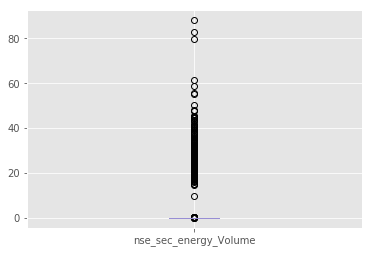

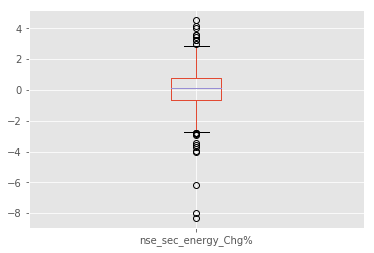

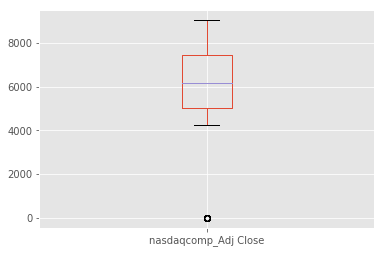

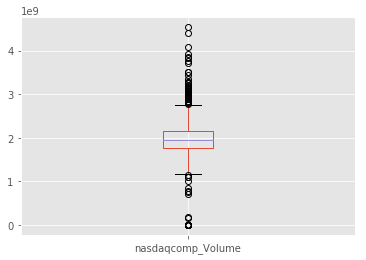

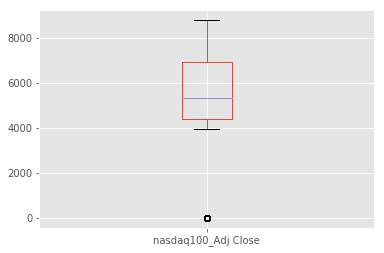

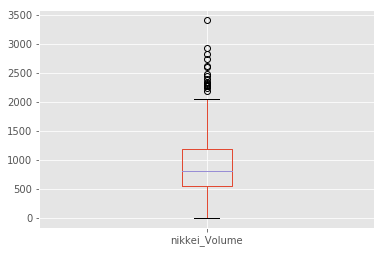

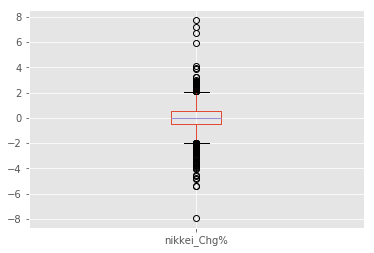

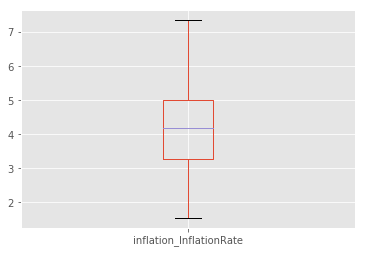

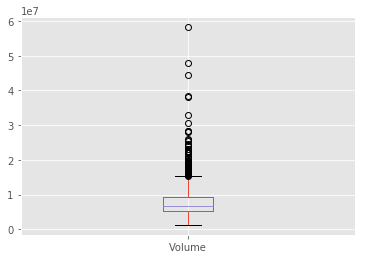

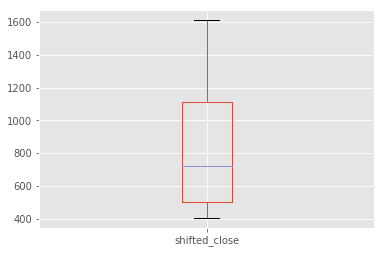

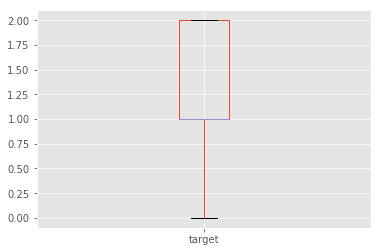

In [382]:
for col in stock_all_df.columns:
    plt.figure()
    stock_all_df.boxplot([col])

In [383]:
#Looking at the box plots, a lot of columns have data points outside the box
#it could be due to the nature of the data in stock domain, due to lot of randomness
#columns like volume, %chg, close cannot be touched as they are real and valid numbers

# Classification

In [384]:
#First 4 years of data from 2015 to 2018 is used for training
#last year 2019 is used for testing

In [385]:
train_df = stock_all_df.loc['2015-01-01':'2018-12-31']
test_df = stock_all_df.loc['2019-01-01':'2019-12-31']
#for classification we use target, shifted_close is not required
train_df.drop(columns=['shifted_close'], inplace=True)
test_df.drop(columns=['shifted_close'], inplace=True)
print(train_df.shape, test_df.shape)

train_df = train_df.astype({"target":'category'})
test_df = test_df.astype({"target":'category'})

(986, 21) (242, 21)


In [386]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 986 entries, 2015-01-01 to 2018-12-31
Data columns (total 21 columns):
nse_Volume                 986 non-null float64
nse_Chg%                   986 non-null float32
crude_Price                986 non-null float64
crude_Volume               986 non-null float64
crude_Chg%                 986 non-null float32
gold_Price                 986 non-null float64
gold_Volume                986 non-null float64
gold_Chg%                  986 non-null float32
silver_Price               986 non-null float64
silver_Volume              986 non-null float64
silver_Chg%                986 non-null float32
nse_sec_energy_Volume      986 non-null float64
nse_sec_energy_Chg%        986 non-null float32
nasdaqcomp_Adj Close       986 non-null float64
nasdaqcomp_Volume          986 non-null float64
nasdaq100_Adj Close        986 non-null float64
nikkei_Volume              986 non-null float64
nikkei_Chg%                986 non-null float32
inflation_In

In [387]:
X_train = train_df.drop("target", axis=1).values
y_train = train_df.pop("target").values
X_test = test_df.drop("target", axis=1).values 
y_test = test_df.pop("target").values

In [388]:
#class balance
print('Train class balance is',y_train.value_counts()/len(y_train))
print('Test class balance is',y_test.value_counts()/len(y_test))

Train class balance is 0.0    0.138945
1.0    0.456389
2.0    0.404665
dtype: float64
Test class balance is 0.0    0.148760
1.0    0.446281
2.0    0.404959
dtype: float64


In [389]:
#Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

print(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(986, 20) (242, 20) (986,) (242,)


In [390]:
print('Actuals are',y_test)

Actuals are [1.0, 1.0, 2.0, 2.0, 2.0, ..., 1.0, 1.0, 1.0, 1.0, 2.0]
Length: 242
Categories (3, float64): [0.0, 1.0, 2.0]


In [391]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier as ET
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from datetime import datetime
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [392]:
#Building a ET model to identify feature importances

In [393]:
et_model = ET()
et_model.fit(X_train, y_train)
feature_df = pd.DataFrame()
feature_df['importances']=list(et_model.feature_importances_)
feature_df['column']=list(train_df.columns)
feature_df.sort_values(by=['importances'], ascending=False)

importances                   column
6      0.056668              gold_Volume
5      0.055028               gold_Price
8      0.053409             silver_Price
2      0.053054              crude_Price
16     0.051563            nikkei_Volume
4      0.051076               crude_Chg%
14     0.050639        nasdaqcomp_Volume
19     0.050390                   Volume
0      0.050289               nse_Volume
13     0.049747     nasdaqcomp_Adj Close
12     0.049564      nse_sec_energy_Chg%
1      0.048954                 nse_Chg%
17     0.048939              nikkei_Chg%
3      0.048670             crude_Volume
10     0.048432              silver_Chg%
11     0.048372    nse_sec_energy_Volume
9      0.048167            silver_Volume
7      0.046910                gold_Chg%
15     0.045457      nasdaq100_Adj Close
18     0.044671  inflation_InflationRate

In [394]:
#creating a generic method that can be reused for all classifiers

In [395]:
def model_executor(lcl_model, lcl_x_train, lcl_x_test, lcl_y_train, lcl_y_test):
    lcl_model.fit(lcl_x_train, lcl_y_train)
    lcl_y_predict = lcl_model.predict(lcl_x_test)
    #print('Prediction ',lcl_y_predict)
    cr = metrics.classification_report(lcl_y_test, lcl_y_predict)
    print('Train Accuracy is', lcl_model.score(lcl_x_train , lcl_y_train))
    print('Test Accuracy is', lcl_model.score(lcl_x_test , lcl_y_test))
    print('Confusion matrix is \n', metrics.confusion_matrix(lcl_y_test, lcl_y_predict))
    print(cr)

In [396]:
dtc = DecisionTreeClassifier()
model_executor(dtc,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 1.0
Test Accuracy is 0.3925619834710744
Confusion matrix is 
 [[ 3  8 25]
 [15 32 61]
 [ 8 30 60]]
              precision    recall  f1-score   support

         0.0       0.12      0.08      0.10        36
         1.0       0.46      0.30      0.36       108
         2.0       0.41      0.61      0.49        98

    accuracy                           0.39       242
   macro avg       0.33      0.33      0.32       242
weighted avg       0.39      0.39      0.37       242



In [397]:
rfc = RandomForestClassifier(n_estimators=1000)
model_executor(rfc,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 1.0
Test Accuracy is 0.47107438016528924
Confusion matrix is 
 [[ 0 21 15]
 [ 0 71 37]
 [ 0 55 43]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.48      0.66      0.56       108
         2.0       0.45      0.44      0.45        98

    accuracy                           0.47       242
   macro avg       0.31      0.37      0.33       242
weighted avg       0.40      0.47      0.43       242



In [398]:
gbcl = GradientBoostingClassifier(n_estimators=10)
model_executor(gbcl,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 0.5862068965517241
Test Accuracy is 0.4090909090909091
Confusion matrix is 
 [[ 1 14 21]
 [ 0 34 74]
 [ 0 34 64]]
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.05        36
         1.0       0.41      0.31      0.36       108
         2.0       0.40      0.65      0.50        98

    accuracy                           0.41       242
   macro avg       0.61      0.33      0.30       242
weighted avg       0.50      0.41      0.37       242



In [399]:
xgb = XGBClassifier(objective='multi:softmax', n_estimators=10)
model_executor(xgb,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 0.5882352941176471
Test Accuracy is 0.4256198347107438
Confusion matrix is 
 [[ 0 23 13]
 [ 2 80 26]
 [ 1 74 23]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.45      0.74      0.56       108
         2.0       0.37      0.23      0.29        98

    accuracy                           0.43       242
   macro avg       0.27      0.33      0.28       242
weighted avg       0.35      0.43      0.37       242



In [400]:
lgbm_classifier = LGBMClassifier(objective='multiclass', num_round=100, 
                                 max_depth=10, learning_rate=.1, num_class=3)
model_executor(lgbm_classifier,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 1.0
Test Accuracy is 0.43388429752066116
Confusion matrix is 
 [[ 0 11 25]
 [ 2 43 63]
 [ 1 35 62]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.48      0.40      0.44       108
         2.0       0.41      0.63      0.50        98

    accuracy                           0.43       242
   macro avg       0.30      0.34      0.31       242
weighted avg       0.38      0.43      0.40       242



In [401]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
model_executor(knn_classifier,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 0.6176470588235294
Test Accuracy is 0.4214876033057851
Confusion matrix is 
 [[ 1 11 24]
 [ 5 30 73]
 [ 1 26 71]]
              precision    recall  f1-score   support

         0.0       0.14      0.03      0.05        36
         1.0       0.45      0.28      0.34       108
         2.0       0.42      0.72      0.53        98

    accuracy                           0.42       242
   macro avg       0.34      0.34      0.31       242
weighted avg       0.39      0.42      0.38       242



In [402]:
svClassifier = SVC(gamma='scale', kernel='rbf', class_weight=None)
model_executor(svClassifier,  X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 0.4898580121703854
Test Accuracy is 0.45454545454545453
Confusion matrix is 
 [[ 0 19 17]
 [ 0 62 46]
 [ 0 50 48]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.47      0.57      0.52       108
         2.0       0.43      0.49      0.46        98

    accuracy                           0.45       242
   macro avg       0.30      0.35      0.33       242
weighted avg       0.39      0.45      0.42       242



In [403]:
#TODO
#Hyperparameter tuning, grid/random search CV
#also try stacking

In [404]:
bootstrap=[True,False]#sampling with replacement yes or no
max_features=[5,'auto',10]#auto is sqrt of number of features
n_estimators=[10,50,100]#The number of trees

param_grid = dict(bootstrap=bootstrap,max_features=max_features,n_estimators=n_estimators)

In [405]:
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv = 10, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.354968 using {'bootstrap': True, 'max_features': 5, 'n_estimators': 100}


In [406]:
#Cross validation may not be riht for time series, just trying

In [407]:
#Fine-tuning Model with Random Search - with Random forest
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1), 
                            param_distributions=param_grid, cv = 10, n_jobs=-1, random_state=1)
random_result = random.fit(X_train_scaled, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.354968 using {'n_estimators': 100, 'max_features': 5, 'bootstrap': True}


In [408]:
max_features=[5,'auto',10]#auto is sqrt of number of features
n_estimators=[50,100,150]#The number of trees
learning_rate = [0.001,0.01,0.1]
max_depth = [5,10]
param_grid = dict(max_features=max_features,n_estimators=n_estimators, 
                  max_depth=max_depth, learning_rate=learning_rate)
model = GradientBoostingClassifier(random_state=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=10)
grid_result = grid.fit(X_train_scaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

Best: 0.456401 using {'learning_rate': 0.001, 'max_depth': 5, 'max_features': 5, 'n_estimators': 50}


In [437]:
final_model = GradientBoostingClassifier(random_state=1, n_estimators = 50, learning_rate = 0.001,
                                        max_depth=5, max_features=5)
model_executor(final_model, X_train_scaled, X_test_scaled, y_train, y_test)

Train Accuracy is 0.4563894523326572
Test Accuracy is 0.4462809917355372
Confusion matrix is 
 [[  0  36   0]
 [  0 108   0]
 [  0  98   0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.45      1.00      0.62       108
         2.0       0.00      0.00      0.00        98

    accuracy                           0.45       242
   macro avg       0.15      0.33      0.21       242
weighted avg       0.20      0.45      0.28       242



In [410]:
#Try more values with Random search cv
#Try for other models 

In [438]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train_scaled, y_train)
print(tpot.score(X_test_scaled, y_test))
tpot.export('tpot_stock_pipeline.py')


Generation 1 - Current best internal CV score: 0.45639132441162894
Generation 2 - Current best internal CV score: 0.45639132441162894
Generation 3 - Current best internal CV score: 0.45639132441162894
Generation 4 - Current best internal CV score: 0.4573860431728452
Generation 5 - Current best internal CV score: 0.4573860431728452
Best pipeline: BernoulliNB(MinMaxScaler(input_matrix), alpha=0.1, fit_prior=True)
0.44214876033057854


In [411]:
#Let's plot ROC AUC for Multiclass

In [412]:
y_train2 = label_binarize(y_train, classes=[0,1,2])

In [413]:
y_test2 = label_binarize(y_test, classes=[0,1,2])

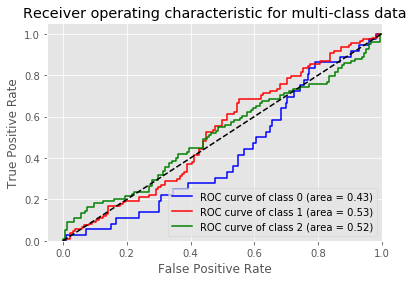

In [414]:
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
plt.style.use('ggplot')

#Plot AUC curve - Multiclass
n_classes = 3

classifier = OneVsRestClassifier(SVC(gamma='scale', kernel='rbf', class_weight=None))
#classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train_scaled, y_train2).decision_function(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [415]:
#NN and DL models

In [416]:
#Lets also build a Deep NN, simple and defaults, to start with
import tensorflow as tf
#tf.set_random_seed(42)
tf.__version__

'2.0.0'

In [417]:
stock_all_df_copy.shape

(1228, 61)

In [418]:
train_df_nn = stock_all_df_copy.loc['2015-01-01':'2018-12-31']
test_df_nn = stock_all_df_copy.loc['2019-01-01':'2019-12-31']
#for classification we use target, shifted_close is not required
train_df_nn.drop(columns=['shifted_close'], inplace=True)
test_df_nn.drop(columns=['shifted_close'], inplace=True)

#train_df_nn = train_df_nn.astype({"target":'category'})
#test_df_nn = test_df_nn.astype({"target":'category'})

print(train_df_nn.shape, test_df_nn.shape)

(986, 60) (242, 60)


In [419]:
X_train_nn = train_df_nn.drop("target", axis=1).values
y_train_nn = train_df_nn.pop("target").values
X_test_nn = test_df_nn.drop("target", axis=1).values 
y_test_nn = test_df_nn.pop("target").values

In [420]:
#Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_nn_scaled = pd.DataFrame(scaler.fit_transform(X_train_nn))
X_test_nn_scaled = pd.DataFrame(scaler.transform(X_test_nn))

print(X_train_nn_scaled.shape, X_test_nn_scaled.shape, y_train_nn.shape, y_test_nn.shape)

(986, 59) (242, 59) (986,) (242,)


In [421]:
num_classes = 3

#Convert labels to one hot encoding
y_train_ohe = tf.keras.utils.to_categorical(y_train_nn, num_classes=num_classes)
y_test_ohe = tf.keras.utils.to_categorical(y_test_nn, num_classes=num_classes)

In [422]:
tf.keras.backend.clear_session()

In [423]:
#Define input layer which has shape (None, 59). None indicates the number of instances
input_layer = tf.keras.layers.Input(shape=(59,))

#Dense layers are defined with linear activation
dense1 = tf.keras.layers.Dense(64, activation='relu')(input_layer)
dropout1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(16, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(8, activation='relu')(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2)(dense4)

#Finally, the output layer gives prediction for the next day's air pressure.
output_layer = tf.keras.layers.Dense(3, activation='softmax')(dropout4)

ts_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
ts_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3840      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

In [424]:
ts_model.fit(x=X_train_nn_scaled, y=y_train_ohe, batch_size=1, epochs=20,
             verbose=1, validation_data=(X_test_nn_scaled, y_test_ohe),
             shuffle=False)

Train on 986 samples, validate on 242 samples
Epoch 1/20
986/986 [==============================] - 3s 3ms/sample - loss: 1.0366 - accuracy: 0.4442 - val_loss: 1.3953 - val_accuracy: 0.4463
Epoch 2/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0169 - accuracy: 0.4371 - val_loss: 1.4352 - val_accuracy: 0.4132
Epoch 3/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0140 - accuracy: 0.4533 - val_loss: 1.2720 - val_accuracy: 0.4380
Epoch 4/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0075 - accuracy: 0.4422 - val_loss: 1.3232 - val_accuracy: 0.4008
Epoch 5/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0030 - accuracy: 0.4665 - val_loss: 1.1773 - val_accuracy: 0.4463
Epoch 6/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0052 - accuracy: 0.4452 - val_loss: 1.0848 - val_accuracy: 0.4463
Epoch 7/20
986/986 [==============================] - 2s 2ms/sample - loss: 1.0040 - accur

In [425]:
#RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [426]:
X_train_nn_scaled_np = X_train_nn_scaled.to_numpy()
X_train_nn_scaled_np = np.reshape(X_train_nn_scaled_np, (X_train_nn_scaled_np.shape[0], X_train_nn_scaled_np.shape[1], 1))

X_test_nn_scaled_np = X_test_nn_scaled.to_numpy()
X_test_nn_scaled_np = np.reshape(X_test_nn_scaled_np, (X_test_nn_scaled_np.shape[0], X_test_nn_scaled_np.shape[1], 1))

print(X_train_nn_scaled_np.shape, X_test_nn_scaled_np.shape)

(986, 59, 1) (242, 59, 1)


In [427]:
tf.keras.backend.clear_session()

rnn_model = Sequential()
rnn_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_nn_scaled_np.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(8, activation='relu'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(3, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 59, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 59, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 59, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 59, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [428]:
rnn_model.fit(x=X_train_nn_scaled_np, y=y_train_ohe, batch_size=1, epochs=20,
             verbose=1, validation_data=(X_test_nn_scaled_np, y_test_ohe),
             shuffle=False)

Train on 986 samples, validate on 242 samples
Epoch 1/20
986/986 [==============================] - 110s 111ms/sample - loss: 1.0442 - accuracy: 0.4412 - val_loss: 1.0184 - val_accuracy: 0.4463
Epoch 2/20
986/986 [==============================] - 110s 111ms/sample - loss: 1.0154 - accuracy: 0.4554 - val_loss: 1.0131 - val_accuracy: 0.4463
Epoch 3/20
986/986 [==============================] - 99s 100ms/sample - loss: 1.0121 - accuracy: 0.4310 - val_loss: 1.0129 - val_accuracy: 0.4463
Epoch 4/20
986/986 [==============================] - 89s 90ms/sample - loss: 1.0091 - accuracy: 0.4473 - val_loss: 1.0118 - val_accuracy: 0.4463
Epoch 5/20
986/986 [==============================] - 84s 86ms/sample - loss: 1.0085 - accuracy: 0.4564 - val_loss: 1.0114 - val_accuracy: 0.4463
Epoch 6/20
986/986 [==============================] - 84s 85ms/sample - loss: 1.0033 - accuracy: 0.4564 - val_loss: 1.0099 - val_accuracy: 0.4463
Epoch 7/20
986/986 [==============================] - 85s 86ms/sample - l